# **Business Cases Course**

<br>

- **Group Project 2022/2023**
- **Academic Year: 2020-2023 | 2nd Semester**
- **Professor: Nuno António**

<br>

- **"Case 1: Hotel Customer segmentation"**
- **Hotel H from independent hotel chain C**
- **This notebook uses the *Case1_HotelCustomerSegmentation.csv* dataset**


<br>

> **Group composed by:**<p>
> Ana Carolina Ottavi, nº 20220541<p>
> Carolina Bezerra, nº 20220392 <p>
> Duarte Girão, nº 20220670<p>
> João Pólvora, nº 20221037<p>
> Luca Loureiro, nº 20221750<p>

## 📖 Introduction
    
Within the scope of __Business Cases for Data Science__, it was proposed a project, where the groups' ability to deliver a customer segmentation in accordance with the different features included in a dataset containing 111.733 records would be tested. However, A, the new marketing manager of the hotel H, realized that the current customer segmentation was not useful for the hotel marketing department, as it only reflected one only customer characteristic, its sales origin.
    
Therefore, the business goal determined for this project was to develop a new customer segmentation and gaining insight on the current customers' characteristics. By understanding the differences between the different segments, organizations can make better strategic choices about opportunities, product definition, positioning, promotions, pricing, and target marketing.

<br>

## 📖Dataset description

This notebook uses the Case1_HotelCustomerSegmentation.csv. The Dataset is related with direct marketing campaigns of a hotel located in Lisbon, hotel H.<br> This hotel H is inserted in a hotel chain C, spread all over the world. <br> Since 2018, there is a new marketing manager in this hotel H, A, which is somehow unsatisfied with hotel H marketing department.


Client information:
- **ID**: Customer ID
- **Nationality**: Nationality of the customer in ISO 3166-1 (Alpha 3) format
- **Age**: Age of the customer
- **DaysSinceCreation**: Number of elapsed days since the customer was created
- **NameHash**: Hash of the customer name
- **DocIDHash**: Hash of the customer personal document identification number (usually passport or ID card)
- **AverageLeadTime**: Average number of days before arrival date the customer makes bookings
- **LodgingRevenue**: Total amount of lodging revenue paid by the customer so far
- **OtherRevenue**: Total amount of other revenue (e.g., food & beverage, spa, etc.) paid by the customer so far

Reservation information:
- **BookingsCanceled**: Number of bookings the customer made but ubsequently canceled
- **BookingsNoShowed**: Number of bookings the customer made but subsequently made a "no-show"
- **BookingsCheckedin**: Number of bookings the customer made, which actually ended up staying
- **PersonNights**: Total person/nights the customer has stayed at the hotel so far.
- **RoomNights**: Total of room/nights the customer has stayed at the hotel so far.
- **DistributionChannel**: Distribution channel normally used by the customer to make bookings at the hotel
- **MarketSegment**: Current market segment of the customer
- **SRHighFloor**: Indication if the customer usually asks for a room in a higher floor (0: No, 1: Yes)
- **SRLowFloor**: Indication if the customer usually asks for a room in a lower floor (0: No, 1: Yes)
- **SRAccessibleRoom**: Indication if the customer usually asks for an accessible room (0: No, 1: Yes)
- **SRMediumFloor**: Indication if the customer usually asks for a room in a middle floor (0: No, 1: Yes)
- **SRBathtub**: Indication if the customer usually asks for a room with a bathtub (0: No, 1: Yes)
- **SRShower**: Indication if the customer usually asks for a room with a shower (0: No, 1: Yes)
- **SRCrib**: Indication if the customer usually asks for a crib (0: No, 1: Yes)
- **SRKingSizeBed**: Indication if the customer usually asks for a room with a king size bed (0: No, 1: Yes)
- **SRTwinBed**: Indication if the customer usually asks for a room with a twin bed (0: No, 1: Yes)
- **SRNearElevator**: Indication if the customer usually asks for a room near the elevator (0: No, 1: Yes)
- **SRAwayFromElevator**: Indication if the customer usually asks for a room away from the elevator (0: No, 1: Yes)
- **SRNoAlcoholInMiniBar**: Indication if the customer usually asks for a room with no alcohol in the mini bar (0: No, 1: Yes)
- **SRQuietRoom**: Indication if the customer usually asks for a room away from the noise (0: No, 1: Yes)


Note: All time-based columns (e.g., Age or DaysSinceCreation) were calculated at the dataset extraction date.

# **1. Initial Setup**

- 1.1) Importing needed libraries
- 1.2) Defining functions

In [1]:
# Install in case its necessary
    # !pip install category_encoders
    # !pip install pandas_profiling
    # !pip install ydata_profiling

# Imports
import category_encoders as ce
import datetime
import math
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import os
import pandas as pd
import pandas_profiling
import seaborn as sns
import scipy.stats as stats
import warnings
import ydata_profiling
warnings.filterwarnings("ignore")

# From sklearn
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.impute import KNNImputer
from sklearn.manifold import TSNE
from sklearn.metrics import recall_score,  f1_score
from sklearn.metrics import silhouette_score, silhouette_samples, pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder


# From other libraries
from datetime import datetime, timedelta
from dateutil import parser
from itertools import cycle,islice, product
from math import ceil
from matplotlib import ticker
from minisom import MiniSom
from os.path import join
from pandas_profiling import ProfileReport
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.stats import chi2_contingency
from yellowbrick.cluster import InterclusterDistance, KElbowVisualizer, SilhouetteVisualizer

# Setting Visual Theme
sns.set_theme(style = 'white', palette = None)

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_24296\2556763482.py:16: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


In [2]:
# Creating get_ss function:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var()*(df.count() - 1))
    return ss  # Return sum of sum of squares of each df variable.

# Creating get_ss_feature function:
def get_ss_feature(df):
    """Get the SS for each variable
    """
    ss_vars = df.var()*(df.count() - 1)
    return ss_vars

# Creating get_r2 function:
def get_r2(df, labels):
    sst = get_ss(df) # Get total sum of squares.
    ssw_labels = df.groupby(by=labels).apply(get_ss)  # Compute ssw for each cluster labels
    ssb = sst - np.sum(ssw_labels)  # Remember: SST = SSW + SSB.
    r2 = ssb / sst
    return r2

# Creating get_r2_feature function:
def get_r2_feature(df, labels):
    """Get the R² for each variable
    """
    sst_vars = get_ss_feature(df)
    ssw_vars = np.sum(df.groupby(labels).apply(get_ss_feature))
    return 1 - ssw_vars/sst_vars

# **2. Data Understanding**

- **2.1) Collect Initial Data: Reading the original file**
- 2.1.1) Reading the original file
- 2.1.2) Making a safety copy of the dataset
- **2.3) Describe Data: General description of data**
- **2.4) Explore Data**
- 2.4.1) Counting the number of rows and columns 
- 2.4.2) Checking the top and bottom from the dataset
- 2.4.3) Checking Data types
- 2.4.4) Checking the number of unique values per feature
- **2.5) Verify Data Quality**
- 2.5.1) Checking Duplicated Values
- 2.5.2) Checking Missing Values
- 2.5.3) Checking Age, AverageLeadTime and DaysSinceCreation
- 2.5.4) Checking NameHash and DocIDHash 
- 2.5.5) Checking BookingsCanceled, BookingsNoShowed and BookingsCheckedIn 
- 2.5.6) Checking PersonsNights and RoomNights
- 2.5.7) Checking LodgingRevenue and OtherRevenue columns
- 2.5.8) Checking SR columns
- 2.5.9) Checking categorical variables

- **2.1) Collect Initial Data: Reading the original file**
- 2.1.1) Reading the original file

In [3]:
df = pd.read_csv('Case1_HotelCustomerSegmentation.csv', sep=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111733 entries, 0 to 111732
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    111733 non-null  int64  
 1   Nationality           111733 non-null  object 
 2   Age                   107561 non-null  float64
 3   DaysSinceCreation     111733 non-null  int64  
 4   NameHash              111733 non-null  object 
 5   DocIDHash             110732 non-null  object 
 6   AverageLeadTime       111733 non-null  int64  
 7   LodgingRevenue        111733 non-null  float64
 8   OtherRevenue          111733 non-null  float64
 9   BookingsCanceled      111733 non-null  int64  
 10  BookingsNoShowed      111733 non-null  int64  
 11  BookingsCheckedIn     111733 non-null  int64  
 12  PersonsNights         111733 non-null  int64  
 13  RoomNights            111733 non-null  int64  
 14  DistributionChannel   111733 non-null  object 
 15  

- **2.1) Collect Initial Data: Reading the original file**
- 2.1.2) Making a safety copy of the dataset

In [4]:
# Make a first security copy of our original dataset.

df_original = df.copy()

- **2.3) Describe Data: General description of data**

In [5]:
# Check descriptive statistics (of main characteristics for each feature) before replacing missing values.
# Here, we can have a good sensibility on data.

df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,111733.0,NaN,NaN,NaN,55867.0,32254.683151,1.0,27934.0,55867.0,83800.0,111733.0
Nationality,111733,199,FRA,16516,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,107561.0,NaN,NaN,NaN,45.639191,17.244952,-10.0,33.0,47.0,58.0,123.0
DaysSinceCreation,111733.0,NaN,NaN,NaN,595.026599,374.657382,36.0,288.0,522.0,889.0,1385.0
NameHash,111733,107584,0x15A713CE687991691A18F6CDC56ABE24979C73CF5D51...,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DocIDHash,110732,103480,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,3032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AverageLeadTime,111733.0,NaN,NaN,NaN,60.833147,85.11532,-1.0,0.0,21.0,95.0,588.0
LodgingRevenue,111733.0,NaN,NaN,NaN,283.851283,379.131556,0.0,0.0,208.0,393.3,21781.0
OtherRevenue,111733.0,NaN,NaN,NaN,64.682802,123.580715,0.0,0.0,31.0,84.0,8859.25
BookingsCanceled,111733.0,NaN,NaN,NaN,0.002282,0.080631,0.0,0.0,0.0,0.0,15.0


In [6]:
# # Visualizing the profilling of our dataset to have a general sensibility on data.

# df_profilling =pandas_profiling.ProfileReport(df)
# df_profilling

**Key Takeawyays**
- Age and AverageLeadTime have at least one negative value
- Age and DocIDHash have some missing values
- AverageLeadTime, LodgingRevenue, OtherRevenue may have outliers

- **2.4) Explore Data**
- 2.4.1) Counting the number of rows and columns 

In [7]:
# Checking the first two on top and on the bottom of the dataset.

df_sliced = df.head(2)
df_sliced = df_sliced.append(df.tail(2))
df_sliced

,ID,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,...,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
0,1,PRT,52.0,440,0x2C371FD6CE12936774A139FD7430C624F1C4D5109CE6...,0x434FD3D59469C73AFEA087017FAF8CA2296493AEABDE...,59,292.0,82.3,1,...,0,0,0,0,0,0,0,0,0,0
1,2,PRT,NaN,1385,0x198CDB98BF37B6E23F9548C56A88B00912D65A9AA0D6...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,61,280.0,53.0,0,...,0,0,0,0,0,0,0,0,0,0
111731,111732,DEU,48.0,36,0xC70AE03F615CB96B0C84CF29419C2DDFE8EC64B77104...,0xF589C016E6988AECD3E3BE793E7D606BBDB6B6D4795C...,66,708.0,185.0,0,...,0,0,0,0,0,0,0,0,0,0
111732,111733,DEU,48.0,36,0xE52EE501843E3108F20BB8F2EC180D8654DF1424EFA2...,0xD539E89183AB389864B7A24B3C1FBC1FE20A40ED02E7...,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0


- **2.4) Explore Data**
- 2.4.2) Checking the top and bottom from the dataset

In [8]:
# Count the number of rows and columns.
# Get more sensibility on data.

df.shape

(111733, 29)

- **2.4) Explore Data**
- 2.4.3) Data types

In [9]:
# Check dataset data types.

df.dtypes

ID                        int64
Nationality              object
Age                     float64
DaysSinceCreation         int64
NameHash                 object
DocIDHash                object
AverageLeadTime           int64
LodgingRevenue          float64
OtherRevenue            float64
BookingsCanceled          int64
BookingsNoShowed          int64
BookingsCheckedIn         int64
PersonsNights             int64
RoomNights                int64
DistributionChannel      object
MarketSegment            object
SRHighFloor               int64
SRLowFloor                int64
SRAccessibleRoom          int64
SRMediumFloor             int64
SRBathtub                 int64
SRShower                  int64
SRCrib                    int64
SRKingSizeBed             int64
SRTwinBed                 int64
SRNearElevator            int64
SRAwayFromElevator        int64
SRNoAlcoholInMiniBar      int64
SRQuietRoom               int64
dtype: object

- **2.4) Explore Data**
- 2.4.4) Checking the number of unique values per feature

In [10]:
# Get the number of unique values per feature.

df.nunique().to_frame(name = 'Number of unique values per feature')

,Number of unique values per feature
ID,111733
Nationality,199
Age,106
DaysSinceCreation,1349
NameHash,107584
DocIDHash,103480
AverageLeadTime,424
LodgingRevenue,12689
OtherRevenue,5338
BookingsCanceled,8


In [11]:
# Get unique values for all the features

columns = df.columns.to_list()

for column in columns:
    #print("\n")
    print("Column Name:", column)
    print(df[column].unique())
    print("\n")

Column Name: ID
[     1      2      3 ... 111731 111732 111733]


Column Name: Nationality
['PRT' 'DEU' 'FRA' 'JPN' 'IRL' 'ESP' 'BEL' 'NLD' 'AUT' 'ITA' 'CHN' 'RUS'
 'POL' 'USA' 'HUN' 'CRI' 'MEX' 'CHE' 'ROU' 'GBR' 'BIH' 'BRA' 'FIN' 'AGO'
 'CAN' 'ZAF' 'TWN' 'GRC' 'AUS' 'ISR' 'BGR' 'SAU' 'SWE' 'ARG' 'ARM' 'CHL'
 'MAR' 'MOZ' 'KOR' 'TUN' 'DNK' 'NOR' 'MYS' 'EGY' 'IND' 'HRV' 'CPV' 'JOR'
 'COD' 'DZA' 'LUX' 'TUR' 'IRN' 'LBY' 'PAN' 'COL' 'VEN' 'GNB' 'CZE' 'AND'
 'SVN' 'PER' 'ATF' 'UGA' 'AZE' 'NZL' 'LTU' 'SRB' 'EST' 'KAZ' 'KWT' 'IDN'
 'UKR' 'SVK' 'MLI' 'ARE' 'BGD' 'THA' 'TZA' 'LVA' 'PHL' 'BHR' 'NAM' 'BOL'
 'CYP' 'SGP' 'CMR' 'MLT' 'URY' 'PAK' 'JAM' 'ECU' 'SYC' 'QAT' 'PRY' 'BRB'
 'OMN' 'TMP' 'ABW' 'LBN' 'AIA' 'SLV' 'DMA' 'CUB' 'VNM' 'GEO' 'IRQ' 'GAB'
 'PYF' 'LIE' 'SEN' 'BLR' 'ISL' 'DOM' 'GUY' 'LCA' 'ATA' 'NGA' 'RWA' 'CIV'
 'ALB' 'MKD' 'MNE' 'GTM' 'GHA' 'MDV' 'MCO' 'MUS' 'SYR' 'TGO' 'LKA' 'SUR'
 'KEN' 'MRT' 'HKG' 'CAF' 'NCL' 'STP' 'UZB' 'KIR' 'SDN' 'PRI' 'KNA' 'TJK'
 'SLE' 'LAO' 'COM' 'ETH' 'FRO' 'B

- **2.5) Verify Data Quality**
- 2.5.1) Checking Duplicated Values

In [12]:
# Check the duplicated values on our dataset.
# We can see that our dataset does not contain any duplicates.

df.duplicated().sum()

0

- **2.5) Verify Data Quality**
- 2.5.2) Checking Missing Values

In [13]:
# Represent a missing values in pandas with a NaN value.

df.replace("", np.nan, inplace=True)

In [14]:
# Check the missing values on our dataset.

df.isna().sum()

ID                         0
Nationality                0
Age                     4172
DaysSinceCreation          0
NameHash                   0
DocIDHash               1001
AverageLeadTime            0
LodgingRevenue             0
OtherRevenue               0
BookingsCanceled           0
BookingsNoShowed           0
BookingsCheckedIn          0
PersonsNights              0
RoomNights                 0
DistributionChannel        0
MarketSegment              0
SRHighFloor                0
SRLowFloor                 0
SRAccessibleRoom           0
SRMediumFloor              0
SRBathtub                  0
SRShower                   0
SRCrib                     0
SRKingSizeBed              0
SRTwinBed                  0
SRNearElevator             0
SRAwayFromElevator         0
SRNoAlcoholInMiniBar       0
SRQuietRoom                0
dtype: int64

<AxesSubplot:>

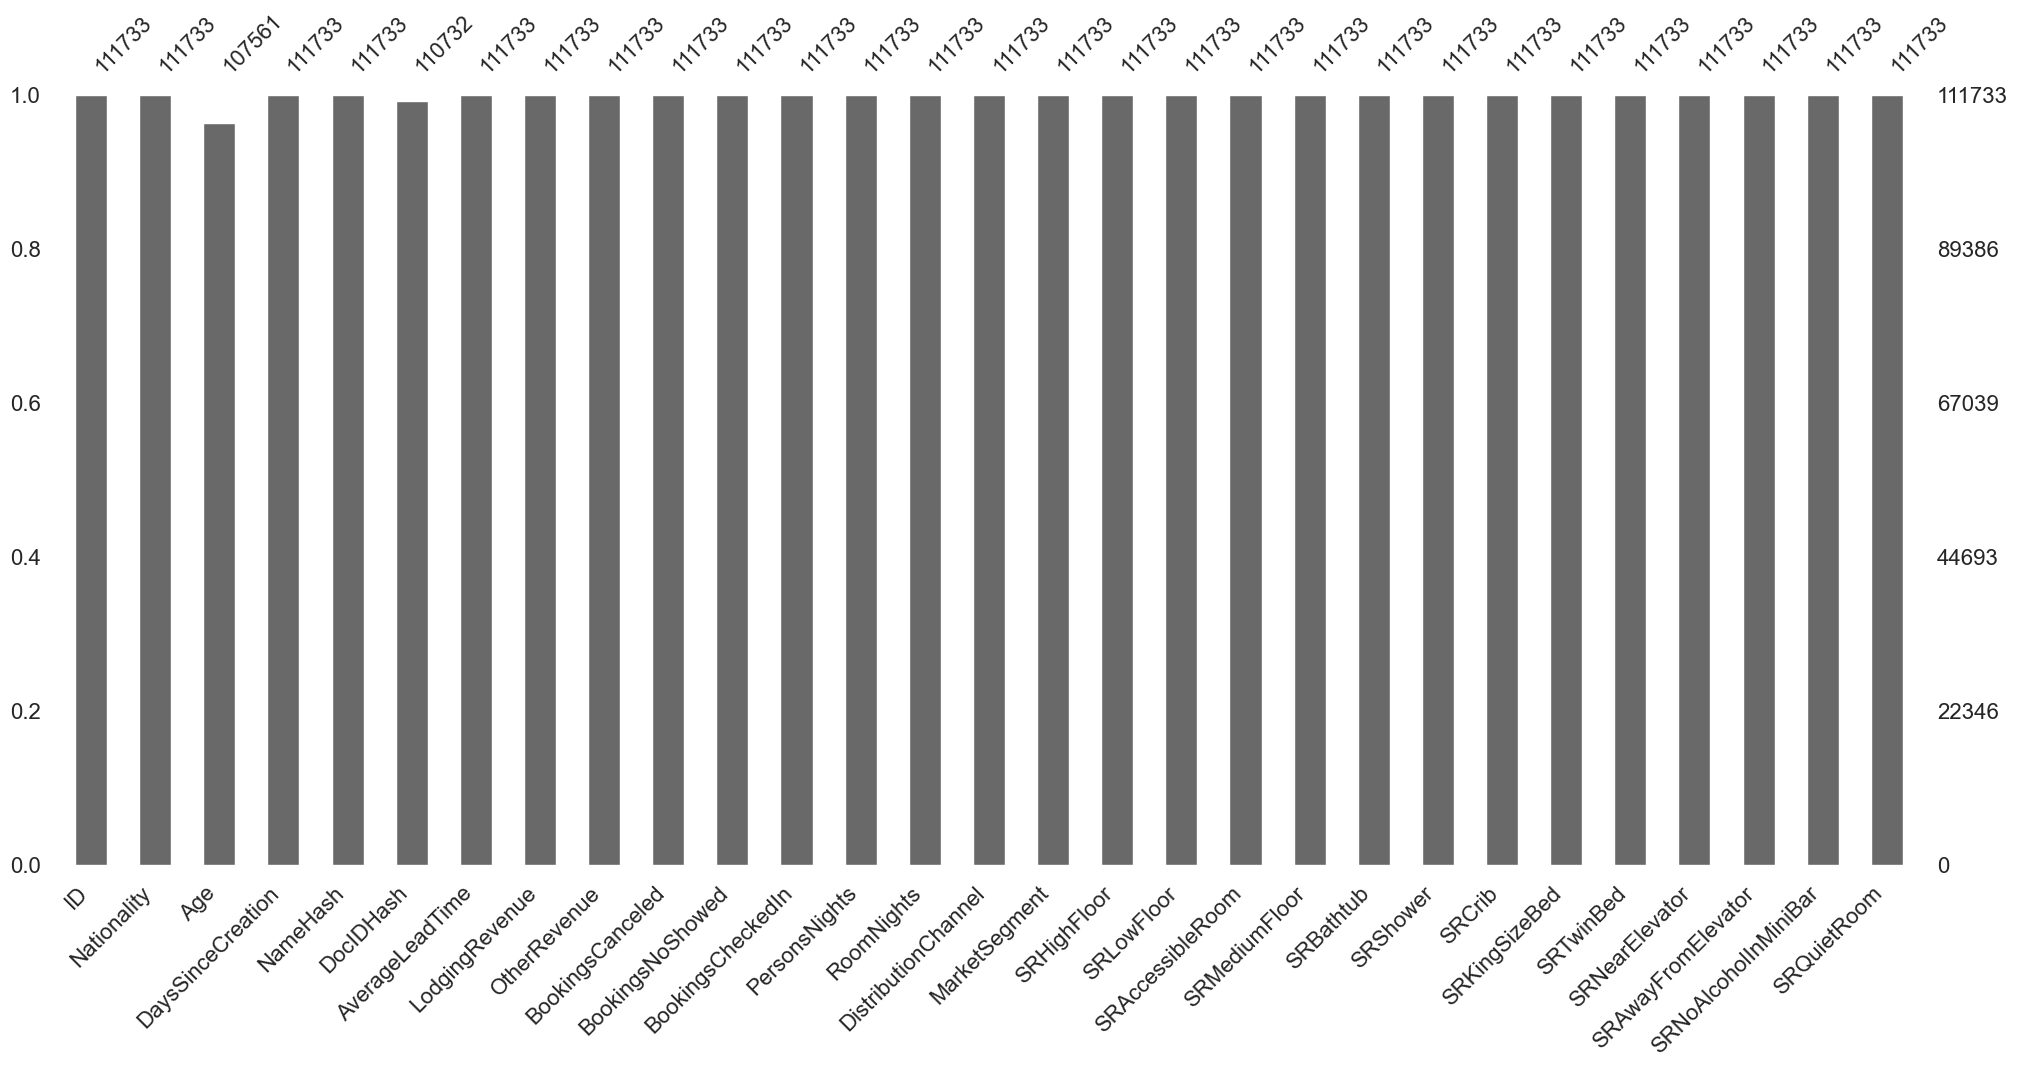

In [15]:
# Taking a visual look at the missing values per variable.
# We can easily check that the variable 'Age' is the feature with more missing values in comparison.

msno.bar(df)

- **2.5) Verify Data Quality**
- 2.5.3) Checking Age, AverageLeadTime and DaysSinceCreation

In [16]:
# AGE
# Checking the unique values of this variables.

df['Age'].sort_values().unique(), print('The total amount of negative values is:', df[df['Age']<0].shape[0])

The total amount of negative values is: 14


(array([-10.,  -9.,  -8.,  -6.,  -5.,   0.,   1.,   2.,   3.,   4.,   5.,
          6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,
         17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,
         28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,
         39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,
         50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,
         61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
         72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,
         83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,
         95.,  97., 110., 111., 114., 115., 123.,  nan]),
 None)

In [17]:
# AVERAGELEADTIME
# Checking the unique values of this variables.

df['AverageLeadTime'].sort_values().unique(), print('The total amount of negative values is:', 
                                                    df[df['AverageLeadTime']<0].shape[0])

The total amount of negative values is: 13


(array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
         12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
         25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
        155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176

In [18]:
# Under our understanding, this can be happen, since:
    # DaysSinceCreation: is the the number of days since the costumer "profile" was registered in the system and the day of extraction. 
    # AverageLeadTime: is the difference between the average reservation day and the day of the day the costumer arrived. 
    
df[df['DaysSinceCreation']<df['AverageLeadTime']].shape[0]

4323

In [19]:
# On this cell, we decided to verify the amount of customers that never checked IN, but had a profile for 1, 
# 2, 3, 4 and 5 years.

print('The number of people who never checked in but have a profile for more than one year is:', 
      df[(df['DaysSinceCreation']>=365)&(df['BookingsCheckedIn']==0)].shape[0])
print('The number of people who never checked in but have a profile for more than two year is:', 
      df[(df['DaysSinceCreation']>=730)&(df['BookingsCheckedIn']==0)].shape[0])
print('The number of people who never checked in but have a profile for more than three year is:', 
      df[(df['DaysSinceCreation']>=1095)&(df['BookingsCheckedIn']==0)].shape[0])
print('The number of people who never checked in but have a profile for more than four year is:', 
      df[(df['DaysSinceCreation']>=1460)&(df['BookingsCheckedIn']==0)].shape[0])
print('The number of people who never checked in but have a profile for more than five year is:', 
      df[(df['DaysSinceCreation']>=1825)&(df['BookingsCheckedIn']==0)].shape[0])

The number of people who never checked in but have a profile for more than one year is: 16884
The number of people who never checked in but have a profile for more than two year is: 1062
The number of people who never checked in but have a profile for more than three year is: 1062
The number of people who never checked in but have a profile for more than four year is: 0
The number of people who never checked in but have a profile for more than five year is: 0


- **2.5) Verify Data Quality**
- 2.5.4) Checking NameHash and DocIDHash 

In [20]:
# Checking for duplicates in the 'DocIDHash' column.
# The explanation can be: due to the use of a company global code (and not from a specific person).
# Counting the total amount of duplicates.

df[df['DocIDHash'].duplicated()].pivot_table(index=['DocIDHash'], aggfunc='size').sort_values(ascending=False).head(5)
df_1 = df[df.duplicated(subset=["DocIDHash"], keep=False)].shape[0]

print('Percentage of data with total duplicates DocIDHash:', np.round(df_1 / df_original.shape[0], 4))

Percentage of data with total duplicates DocIDHash: 0.1015


In [21]:
# Checking for duplicates in the 'NameHash' column.
# The explanation can be: 
    # Cases where the person forget its DocID, for example. For example, a customer can deliver a national ID card in one time
    # and a passport in another time, for example.
    # Another possibility, would be the reservation made by two different people with the same exact name (first and last name, 
    # for example), which is possible.
    # We accept some noise for now, and decided to keep this for now.
# Counting the total amount of duplicates.

df[df['NameHash'].duplicated()].pivot_table(index=['NameHash'], aggfunc='size').sort_values(ascending=False).head(5)
df_2 = df[df.duplicated(subset=["NameHash"], keep=False)].shape[0]

print('Percentage of data with total duplicates NameHash:', np.round(df_2 / df_original.shape[0], 4))

Percentage of data with total duplicates NameHash: 0.0647


In [22]:
# Do these DocIDHash duplicate entries have the same client name? 
# Yes, there are some. This must represent the same person, and so, we assumed that it corresponds to an error in the system.
# Counting all the duplicated values on columns "NameHash", "DocIDHash"
# Only represents 5%, so we decided to eliminate this rows in data preparation.

df[df[['DocIDHash','NameHash']].duplicated()].groupby('DocIDHash')['NameHash'].count().sort_values(ascending=False).head(5)
df_3 = df[df.duplicated(subset=["NameHash","DocIDHash"], keep=False)]# .shape[0]

print('Percentage of data with total duplicates DocIDHash and NameHash:', np.round(df_3.shape[0] / df_original.shape[0], 4))

Percentage of data with total duplicates DocIDHash and NameHash: 0.0527


- **2.5) Verify Data Quality**
- 2.5.5) Checking BookingsCanceled, BookingsNoShowed and BookingsCheckedIn 

In [23]:
# BOOKINGSCANCELED
# Checking the main values amount of this variables.
# Since this variables present a reduce variability, we decided to remove from the dataset.

df['BookingsCanceled'].value_counts().sort_values(ascending=False).head(5)

0    111567
1       125
2        19
3        11
4         8
Name: BookingsCanceled, dtype: int64

In [24]:
# BOOKINGSCHECKEDIN
# Checking the main values amount of this variables.
# We can see that around 30% of the data set (33198 records) have never checked in.

df['BookingsCheckedIn'].value_counts().sort_values(ascending=False).head(5)

1    76474
0    33198
2     1634
3      201
4       57
Name: BookingsCheckedIn, dtype: int64

In [25]:
# So, there is a subset of 0.2971 of our dataset who never checked in.
# The information we can collect from this dataset is not as much reliable as the information collected
# from costumers who have at least one "check in" in the hotel. There is no validation over this data
# by the hotel's staff, and in same why, this can increase the noise in our analysis.
# So, since this is a very significant percentage of the dataset, we will check whether all this records have 
# zero revenue, and take a final decision about it.

df_no_checkin = df[(df["BookingsCheckedIn"]==0)]

print('Percentage of data with total revenue null values:', 
      np.round(df_no_checkin.shape[0] / df_original.shape[0], 4))

Percentage of data with total revenue null values: 0.2971


In [26]:
# BOOKINGSNOSHOWED
# Checking the main values amount of this variables.
# Since this variables present a reduce variability, we decided to remove from the dataset.

df['BookingsNoShowed'].value_counts().sort_values(ascending=False).head(5)

0    111676
1        48
2         8
3         1
Name: BookingsNoShowed, dtype: int64

**Key Takeaways**
- From these three "Booking types" variables, only BookingsCheckedIn presents some variance overall. 
- The following variables, are highly unbalanced and do not bring value to the dataset: BookingsCanceled e BookingsNoShowed.
- In this sense, we found no relevant for our customer segmentation and removed them from the dataset in Data Preparation phase.

- **2.5) Verify Data Quality**
- 2.5.6) Checking PersonsNights and RoomNights 

In [27]:
# PERSONSNIGHTS
# Checking the main values amount of this variables.

df['PersonsNights'].value_counts().sort_values(ascending=False).head()

0    33202
6    16328
4    12926
2    11815
8    10245
Name: PersonsNights, dtype: int64

In [28]:
# ROOMNIGHTS
# Checking the main values amount of this variables.

df['RoomNights'].value_counts().sort_values(ascending=False).head(10)

0    33198
3    20706
2    17484
4    14050
1    13665
5     6248
7     2570
6     2424
8      505
9      271
Name: RoomNights, dtype: int64

In [29]:
# Taking a look at the the relationship between these two features, that must be highly correlated.
# We can see that most of the values are in the diagonal, meaning that they are highly related, confirming our understanding.

pd.crosstab(df['PersonsNights'], df['RoomNights'])

RoomNights,0,1,2,3,4,5,6,7,8,9,...,40,42,48,49,51,59,88,95,116,185
PersonsNights,,,,,,,,,,,,,,,,,,,,,
0,33198,0,2,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,5145,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,6830,4980,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,1272,36,3655,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,393,10413,16,2102,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,25,8,30,9,1041,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,1649,14248,16,8,407,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,1,9,11,13,3,251,1,2,...,0,0,0,0,0,0,0,0,0,0
8,0,0,372,5,9769,10,7,5,77,0,...,0,0,0,0,0,0,0,0,0,0


- **2.5) Verify Data Quality**
- 2.5.7) Checking LodgingRevenue and OtherRevenue columns

In [30]:
# Here, we also try to investigate all the records that have a total revenue equal to 0. 
# This customers do not represent a relevant target for our project, in our opinion.
# This cases could represent:
    # An offer from someone else to the customer who is scheduling a reservation.
    # Cases where were created a loyalty client, but it was not created a reservation.
# Additionally, we also tried to understand whether this customers have never checkedIN.
# In this sense, we created two new variables, where we stored our dataset under this conditions:
    # df_4, corresponding to costumers with zero revenue.
    # df_5, corresponding to costumers with zero revenue and that never checked in. 
# In conclusion:
    # We believe that a customer with zero revenue per si, does not mean necessarly that he/she did not checkedIN.
    # After discussing, we believe that customers that have zero revenue and have never checkedin, 
    # do not represent reliable data and are not useful for our analysis.
    # In this sense, in section 3 we opted to delete our records whose 'BookingsCheckedIn' is equal to zero, 
    # since we can not trust at 100% on the information about this customers.
    # The majority of the costumers have revenue equal to zero, as we can see, but we decided to keep those costumers
    # whose revenue is equal zero but have already checkedIN at least one time in past.

df_4 = df[(df["LodgingRevenue"]==0) & (df["OtherRevenue"]==0)]
df_5 = df[(df["LodgingRevenue"]==0) & (df["OtherRevenue"]==0) & (df["BookingsCheckedIn"]==0)]

print('Percentage of data with total revenue null values:', 
      np.round(df_4.shape[0] / df_original.shape[0], 4))
print('Percentage of data with total revenue null values and never checkedIN:', 
      np.round(df_5.shape[0] / df_original.shape[0], 4))

Percentage of data with total revenue null values: 0.3002
Percentage of data with total revenue null values and never checkedIN: 0.2971


In [31]:
# We decided to eliminate this variable latter in data preparation as long as it must be en error.
# We do not have any explanation for a customer that has revenue even though did not booked in any time in the past.

df_6 = df[~((df['LodgingRevenue']==0)&(df['OtherRevenue']==0))]
df_7 = df_6[df_6['BookingsCheckedIn']==0]
df_7

,ID,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,...,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
70579,70580,PRT,NaN,410,0x68573FCBE31A16536960950762FD290A46A8BDEE8F06...,NaN,114,249.3,18.0,0,...,0,0,0,0,0,0,0,0,0,0


- **2.5) Verify Data Quality**
- 2.5.8) Checking SR columns

In [32]:
# Before defining metric and categorical features, we decided to take 
# a deep look at "SPECIAL REQUESTS" variables to see how they are distributed between 0 and 1.

sr = ['SRHighFloor', 'SRLowFloor', 'SRAccessibleRoom', 
      'SRMediumFloor', 'SRBathtub', 'SRShower', 'SRCrib',
      'SRKingSizeBed', 'SRTwinBed', 'SRNearElevator', 
      'SRAwayFromElevator', 'SRNoAlcoholInMiniBar', 'SRQuietRoom']

df[sr].apply(pd.Series.value_counts)

,SRHighFloor,SRLowFloor,SRAccessibleRoom,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
0,106983,111587,111708,111647,111383,111551,109925,71144,94212,111696,111331,111711,101932
1,4750,146,25,86,350,182,1808,40589,17521,37,402,22,9801


In [33]:
# We defined our virtual threshold as 95%.
# So, we decided to just kept the variables below this threshold, because the remaining do not bring us much valid information,
# once they are very, very unbalanced:
    # SRKingSizeBed
    # SRTwinBed
    # SRQuietRoom

# See detail below:
for feat in sr:
    print('Feature: {feat}')
    print(df[feat].value_counts()/ len(df))  # Very unbalanced
    print("\n")

Feature: {feat}
0    0.957488
1    0.042512
Name: SRHighFloor, dtype: float64


Feature: {feat}
0    0.998693
1    0.001307
Name: SRLowFloor, dtype: float64


Feature: {feat}
0    0.999776
1    0.000224
Name: SRAccessibleRoom, dtype: float64


Feature: {feat}
0    0.99923
1    0.00077
Name: SRMediumFloor, dtype: float64


Feature: {feat}
0    0.996868
1    0.003132
Name: SRBathtub, dtype: float64


Feature: {feat}
0    0.998371
1    0.001629
Name: SRShower, dtype: float64


Feature: {feat}
0    0.983819
1    0.016181
Name: SRCrib, dtype: float64


Feature: {feat}
0    0.636732
1    0.363268
Name: SRKingSizeBed, dtype: float64


Feature: {feat}
0    0.843189
1    0.156811
Name: SRTwinBed, dtype: float64


Feature: {feat}
0    0.999669
1    0.000331
Name: SRNearElevator, dtype: float64


Feature: {feat}
0    0.996402
1    0.003598
Name: SRAwayFromElevator, dtype: float64


Feature: {feat}
0    0.999803
1    0.000197
Name: SRNoAlcoholInMiniBar, dtype: float64


Feature: {feat}
0    0.9122

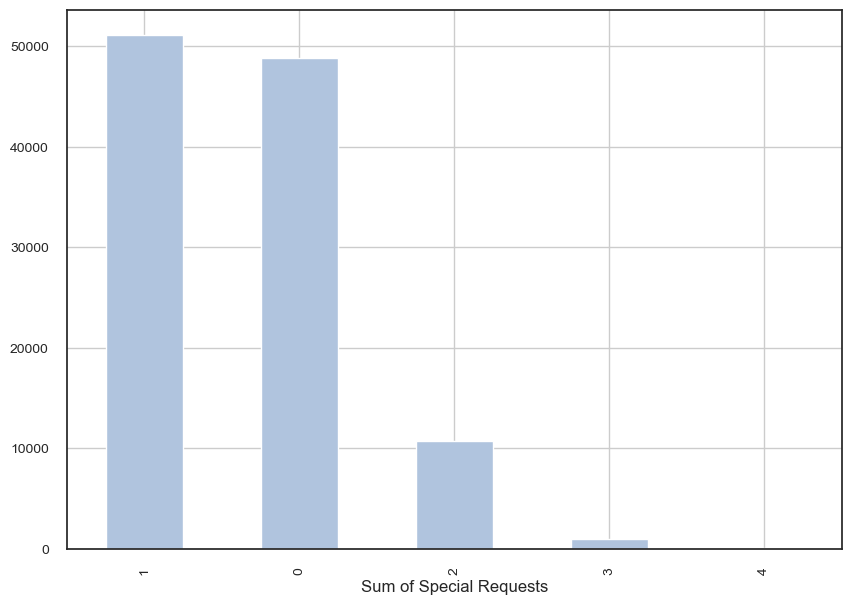

In [34]:
# We decided to create a new variable with the sum of all 'SR' variables. 
# This helps us to understand the amount of request per client.
# After taking a look at the graph, we can see that there are customers with either 0, 1, 2, 3 or 4 Special Requests. 
# However, the majority of the customers had 0 or 1 Special Request.

# setting visual theme
sns.set_theme(style = 'white', palette = None)

# Get a column for total sum of special requests
df['TotalSR']=df[['SRHighFloor', 'SRLowFloor', 'SRAccessibleRoom', 
                  'SRMediumFloor', 'SRBathtub', 'SRShower', 'SRCrib',
                  'SRKingSizeBed', 'SRTwinBed', 'SRNearElevator', 
                  'SRAwayFromElevator', 'SRNoAlcoholInMiniBar', 'SRQuietRoom']].sum(axis=1)

# Get unique values of the sum of special requests for each customer
df['TotalSR'].unique() 

# Customize
ax = df['TotalSR'].value_counts().plot(kind='bar', figsize=(10,7), color = 'lightsteelblue', fontsize=10)
ax.set_xlabel("Sum of Special Requests", fontsize=12);
ax.grid(True)

**Key Takeaways**
- Special Requests features have a low variance overall. 
- The exceptions we found out, were regarding variables: SRKingSizeBed, SRTwinBed, SRQuietRoom.	
- In this sense, we found no relevant for our customer segmentation and removed them from the dataset in Data Preparation Section.

- **2.5) Verify Data Quality**
- 2.5.9) Checking categorical variables

In [35]:
# Taking a close look at the relationship between DistributionChannel and both Revenue Types.

df.groupby('DistributionChannel')['LodgingRevenue', 'OtherRevenue'].sum()

,LodgingRevenue,OtherRevenue
DistributionChannel,,
Corporate,1027637.10,211608.75
Direct,4981176.07,1089448.70
GDS Systems,201156.07,24981.11
Travel Agent/Operator,25505586.16,5901164.96


In [36]:
# Exploration of categorical variables: cross table of MarketSegment and DistributionChannel variables.
# The majority of the Distribution Channels are correctly associated to its corresponding actual Market Segment.

categorical_table = pd.crosstab(index=df['DistributionChannel'], columns=df['MarketSegment'])
categorical_table

# However, here regarding the 'MarketSegment' variable, the main goal of our business case consists in creating
# a new customer segmentation, for the new marketing manager, A.
# So, taking this into consideration, we found that the current (soon to become old) customer segmentation, 
# which corresponds to the column'MarketSegment' is no longer relevant. In this sense, we decided to delete this column
# in 'Data Preparation' phase.

MarketSegment,Aviation,Complementary,Corporate,Direct,Groups,Other,Travel Agent/Operator
DistributionChannel,,,,,,,
Corporate,281,19,2204,13,482,37,99
Direct,0,510,51,15970,171,151,30
GDS Systems,0,0,2,7,5,677,5
Travel Agent/Operator,7,128,674,373,10803,62815,16219


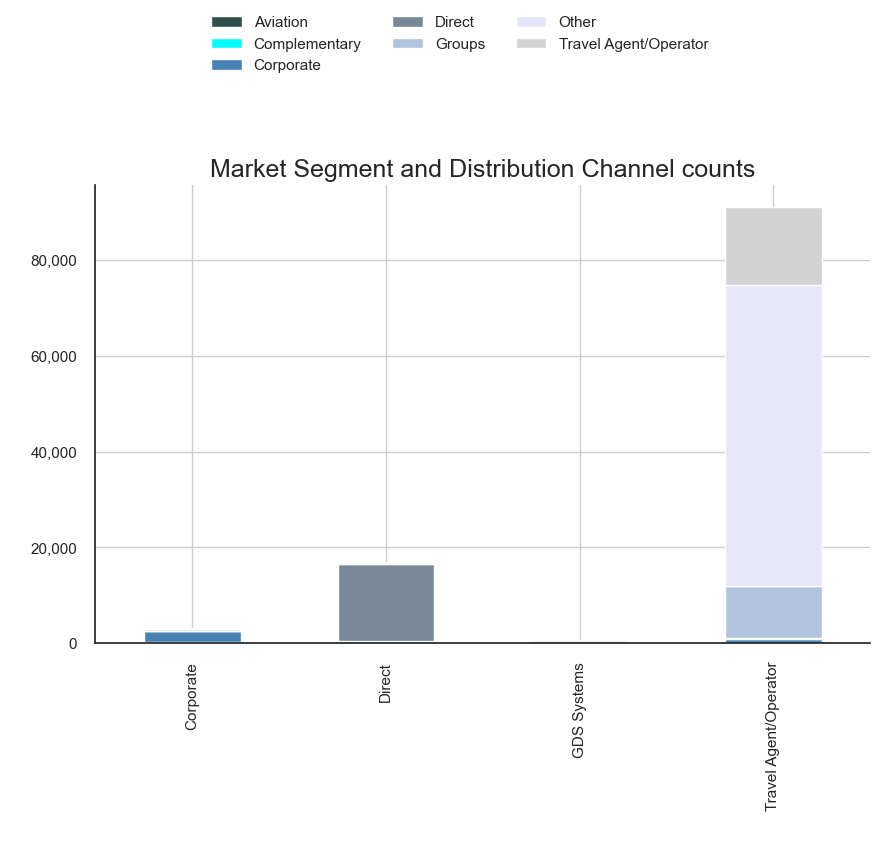

In [37]:
# Visualization of the cross table above - MarketSegment and DistributionSegment

# setting visual theme
sns.set_theme(style = 'white', palette = None)

# Make a list by cycling through the colors you care about
# to match the length of your data.
my_colors = list(islice(cycle(['darkslategrey', 'aqua', 'steelblue', 'lightslategrey', 'lightsteelblue', 'lavender', 'lightgrey']), None, len(df)))

# sort the DataFrame df in ascending order of the 'DistributionChannel' column 
categorical_table_sorted = categorical_table.sort_values('DistributionChannel')


fig, ax = plt.subplots(figsize=(10,7))
categorical_table_sorted.plot(kind="bar",
                       ax=ax,
                       stacked=True,
                       color=my_colors)

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
sns.despine()
plt.title("Market Segment and Distribution Channel counts", fontsize=18)
plt.ylabel(" ")
plt.xlabel(" ", labelpad=18)
plt.rc('axes', labelsize=18)
handles, labels = ax.get_legend_handles_labels()

# Add a legend
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.85])
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.47, 1.40),
    ncol=3, 
)

# Customize
ax.grid(True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


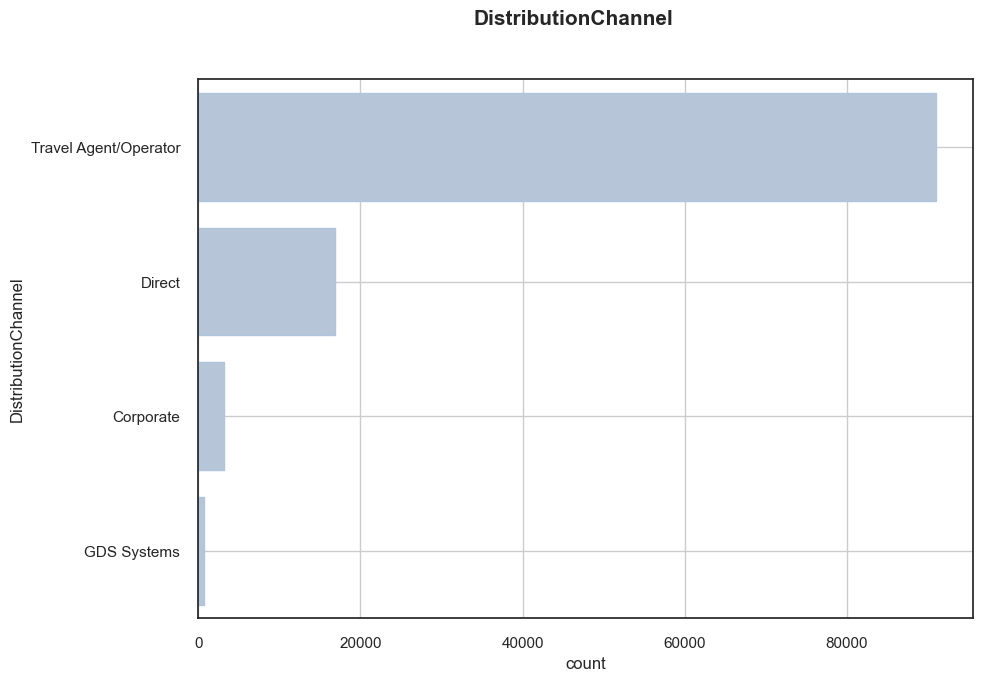

In [38]:
# Setting visual theme
sns.set_theme(style = 'white', palette = None)

# Plot
plt.figure(figsize=(10,7))

sns.countplot(data = df,
              y = df['DistributionChannel'],
              color='lightsteelblue',
              edgecolor='lightsteelblue',
              order = df['DistributionChannel'].value_counts().index
              )
# Layout
plt.suptitle('DistributionChannel', fontsize = 15, fontweight = 'bold')
plt.legend(title='', loc='lower right', prop={'size': 10})
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


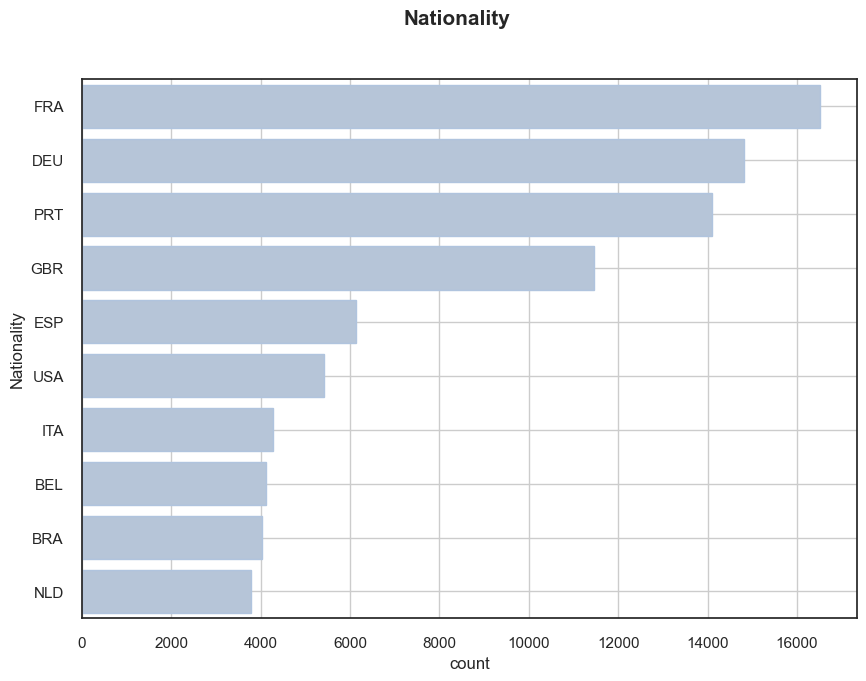

In [39]:
# Setting visual theme
sns.set_theme(style = 'white', palette = None)

# Plot
plt.figure(figsize=(10,7))

sns.countplot(
                data = df,
                y = df['Nationality'],
                color='lightsteelblue',
                edgecolor='lightsteelblue',
                order=df.Nationality.value_counts().iloc[:10].index
             )
# Layout
plt.suptitle('Nationality', fontsize = 15, fontweight = 'bold')
plt.legend(title='', loc='lower right', prop={'size': 10})
plt.grid()
plt.show()

In [40]:
# Nationality and MarketSegment
# As we saw previously above, we have a very high-cardinality for 'Nationality'. 
# It means that we it is difficult to preprocess through a one-hot encoding since it will lead to a very high curse of dimensionality.
# Column 'MarketSegment' also presents some cardinality.
# So, we decided to reduce the cardinality of both 'Nationality' and 'MarketSegment' features.

# In this sense, we defined a function called 'lower_cardinality' that chooses the most frequent categories for each 
# high-cardinality column and replaces all other (less frequent) categories with 'Other'.

def lower_cardinality(df, column, threshold=0.5):
    limit = int(threshold * len(df[column]))
    counter = 0
    most_frequent = []
    categories = [feature for feature in df[column].value_counts().index if feature != 'Other']
    
    for feature in categories:
        counter += df[column].value_counts()[feature]
        if counter <= limit:
            most_frequent.append(feature)
        else:
            break
    
    df[column] = df[column].apply(lambda x: x if x in most_frequent else 'Other')
    return df[column]

df.shape

(111733, 30)

In [41]:
# Applying the function above to the feature 'Nationality', in order to reduce dimensionality.

df['Nationality'] = lower_cardinality(df, 'Nationality')
df['Nationality'].unique()

array(['PRT', 'DEU', 'FRA', 'Other'], dtype=object)

In [42]:
# NATIONALITY
# Checking the unique values of this variables.

df['Nationality'].value_counts().sort_values(ascending=False).head(5)

Other    66311
FRA      16516
DEU      14805
PRT      14101
Name: Nationality, dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


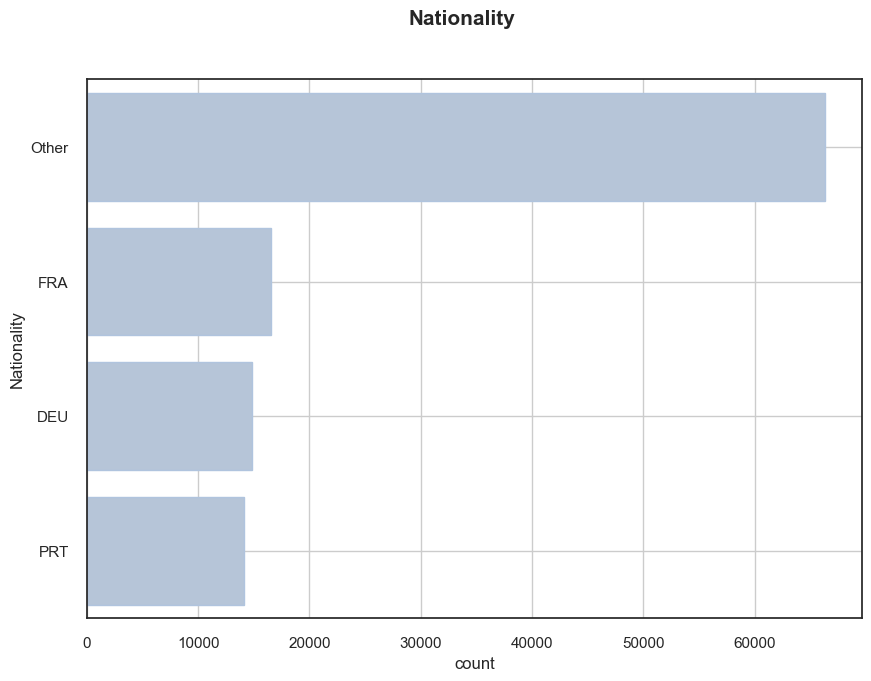

In [43]:
# Setting visual theme
sns.set_theme(style = 'white', palette = None)

# Plot
plt.figure(figsize=(10,7))

sns.countplot(
                data = df,
                y = df['Nationality'],
                color='lightsteelblue',
                edgecolor='lightsteelblue',
                order=df.Nationality.value_counts().iloc[:10].index
             )
# Layout
plt.suptitle('Nationality', fontsize = 15, fontweight = 'bold')
plt.legend(title='', loc='lower right', prop={'size': 10})
plt.grid()
plt.show()

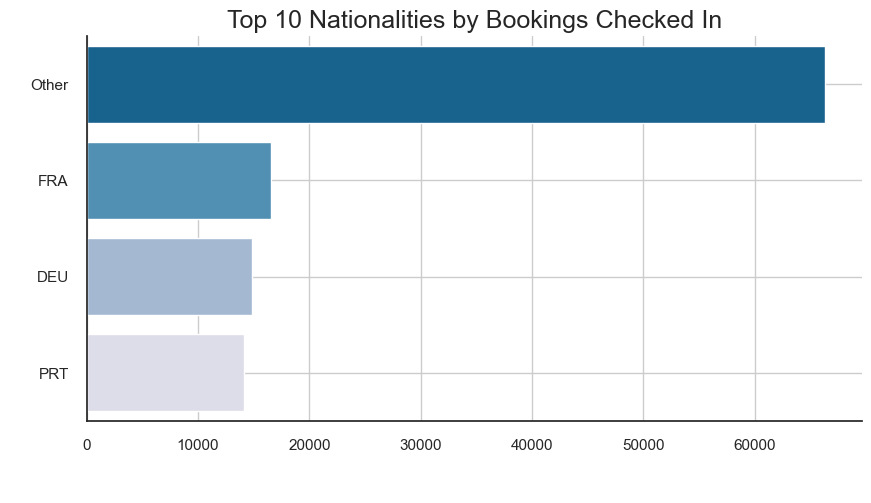

In [44]:
# Visualization of the cross table above - BookingsCheckedIn and Nationality

# Subset 
tmp = df.groupby('Nationality', as_index=False)[['BookingsCheckedIn']].count().sort_values('BookingsCheckedIn', ascending=False)[:10] 

# Plot
plt.figure(figsize = (10, 5))
sns.barplot(data=tmp,y='Nationality',x='BookingsCheckedIn', palette= 'PuBu_r')


# Setting visual theme
sns.set_theme(style = 'white', palette = None)


# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
sns.despine()
plt.title("Top 10 Nationalities by Bookings Checked In", fontsize=18)
plt.ylabel(" ")
plt.xlabel(" ", labelpad=18)
plt.rc('axes', labelsize=18)
plt.grid()

In [45]:
# Applying the function above to the feature 'MarketSegment', in order to reduce dimensionality.

df['MarketSegment'] = lower_cardinality(df, 'MarketSegment', threshold=0.4)
df['MarketSegment'].unique()

array(['Other', 'Travel Agent/Operator', 'Direct', 'Groups'], dtype=object)

In [46]:
# Taking a close look at the relationship between 'MarketSegment' and both Revenue Types.

df.groupby('MarketSegment')['LodgingRevenue', 'OtherRevenue'].sum()

,LodgingRevenue,OtherRevenue
MarketSegment,,
Direct,5014527.22,1090783.07
Groups,3099146.46,788664.73
Other,20102710.46,4202775.73
Travel Agent/Operator,3499171.26,1144979.99


# **3. Data Preparation**

- **3.1) Selecting data**
- 3.1.1) Removing unnecessary rows from Data Exploration
- 3.1.2) Removing unnecessary features from Data Exploration
- 3.1.3) Defining metric and categorical features
- **3.2) Cleaning data**
- 3.2.1) Dealing with missing values
- 3.2.2) Changing Data Types
- 3.2.3) Histograms Analysis
- 3.2.4) Boxplots Analysis
- 3.2.4.1) Manual Removal
- 3.2.4.2) IQR Removal
- 3.2.5) Correlations Analysis
- 3.2.6) Removing unnecessary features from section 3.2
- **3.3) Construct data**
- 3.3.1) Creating new variables
- 3.3.2) Removing unnecessary features from section 3.3
- 3.3.3) Rechecking Correlations Analysis
- 3.3.4) OHE
- **3.4) Integrate/merge data**
- **3.5) Format data**
- 3.5.1) Normalizing data
- 3.5.2) PCA

* __Summary of main Conclusions from Section 2: Data Understanding__: <p>
> 1) - __Age__ has 14 negative values, which it´s impossible.<p>
> 2) - __AverageLeadTime__ has also 13 negative values, which it´s also impossible.<p>
> 3) - __NameHash__ and __DocIDHash__ that are simultaneously negative, must be deleted, there is some mistake.<p>
> 4) - __DaysSinceCreation__ must have a value higher or equal than __AverageLeadTime__. We must deleted the cases where this condition is not verified. <p>
> 5) - __BookingsCheckedIn__ equal to zero, do not represent much reliable data. In this sense, we deleted all records in ths situation, which means that we dropped 30% of our original dataset.<p>

- **3.1) Selecting data**
- 3.1.1) Removing unnecessary rows from Data Exploration

In [47]:
# We removed negative values for Age, which is impossible.
# We considered that '0' can be rounded for recenty born childs.

df = df[~df['Age'].isin([-10, -9, -8, -6, -5])]

print('Percentage of data kept after removing Age values:', np.round(df.shape[0] / df_original.shape[0], 4))

Percentage of data kept after removing Age values: 0.9999


In [48]:
# We removed negative values for AverageLeadTime, which is impossible.
# We considered that '0' can be rounded for recenty born childs.

df = df[~df['AverageLeadTime'].isin([-1])]

print('Percentage of data kept after removing AverageLeadTime values:', np.round(df.shape[0] / df_original.shape[0], 4))

Percentage of data kept after removing AverageLeadTime values: 0.9998


In [49]:
# Deleting all records that have the same NameHash and the same DocIDHash.

df.drop_duplicates(subset=["NameHash","DocIDHash"], keep=False, inplace=True)

# Checking the number of records that were currently kept.

print('Percentage of data kept after removing ID duplicates:', np.round(df.shape[0] / df_original.shape[0], 4))

Percentage of data kept after removing ID duplicates: 0.947


In [50]:
# Deleting the records where the 'AverageLeadTime' is higher than 'DaysSinceCreation'.
# Under our interpretation, it could only be, at maximum, equal, in those cases where a customer booked at the
# day of the profile registration, and checked in at the time of the data extraction.

df = df[~df['DaysSinceCreation']<df['AverageLeadTime']]

print('Percentage of data kept after removing AverageLeadTime values below DaysSinceCreation:', 
      np.round(df.shape[0] / df_original.shape[0], 4))

Percentage of data kept after removing AverageLeadTime values below DaysSinceCreation: 0.947


In [51]:
# We decided to delete all the customers that arrived never checkedIN, although their profile is registed for over
# two years from the date of the database extraction. 
# This criteria, drops 1062 that booked at least with 2 years in advance. This clients are not representative of our costumer
# segmentation, and in this sense, we decided to dropped them.

# df = df[(df['DaysSinceCreation']>=730)&(df['BookingsCheckedIn']==0)]#.shape[0]
df = df.drop(df[(df['DaysSinceCreation'] >= 730) & (df['BookingsCheckedIn'] == 0.0)].index)

print('The number of people who never checked in but have a profile for more than two year is:', 
      np.round(df.shape[0] / df_original.shape[0], 4))

The number of people who never checked in but have a profile for more than two year is: 0.9382


In [52]:
# We removed all records where BookingsCheckedIn is at least one, which means that from no one.
# we focus our analysis on the costumers who have already some experience in the hotel.

df = df[~(df["BookingsCheckedIn"]==0)]

print('Percentage of data kept after removing costumers who have never checkIN:', 
      np.round(df.shape[0] / df_original.shape[0], 4))

Percentage of data kept after removing costumers who have never checkIN: 0.6621


- **3.1) Selecting data**
- 3.1.2) Removing unnecessary features from Data Exploration

In [53]:
# RELEVANCY
# Dropping the following three features, which have high cardinality and does not provide any relevant informations: 
    # ID
    # NameHash
    # DocIDHash 

df.drop(columns=['ID','NameHash', 'DocIDHash'], inplace=True)
df.head(1)

,Nationality,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,...,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom,TotalSR
0,PRT,52.0,440,59,292.0,82.3,1,0,2,6,...,0,0,0,0,0,0,0,0,0,0


In [54]:
# Dropping the two variables related to 'Bookings', that we have checked, on Data Exploration, that were highly unbalanced.

df.drop(columns=['BookingsCanceled','BookingsNoShowed'], inplace=True)
df.head(1)

,Nationality,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCheckedIn,PersonsNights,RoomNights,DistributionChannel,...,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom,TotalSR
0,PRT,52.0,440,59,292.0,82.3,2,6,4,Corporate,...,0,0,0,0,0,0,0,0,0,0


In [55]:
# Dropping the variable 'MarketSegment', which corresponds to the old customer segmentation.
# We aim, with this work, to provide a new customer segmentation for the marketing department.

df.drop(columns=['MarketSegment'], inplace=True)
df.head(1)

,Nationality,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCheckedIn,PersonsNights,RoomNights,DistributionChannel,...,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom,TotalSR
0,PRT,52.0,440,59,292.0,82.3,2,6,4,Corporate,...,0,0,0,0,0,0,0,0,0,0


In [56]:
# In accordance with what we explained in the cell above, we removed the variables that are highly unbalanced.

df.drop(columns=['SRHighFloor','SRLowFloor', 'SRAccessibleRoom', 
                 'SRMediumFloor', 'SRBathtub', 'SRShower', 'SRCrib',
                 'SRNearElevator', 'SRAwayFromElevator', 'SRNoAlcoholInMiniBar', 'TotalSR'], inplace=True)
df.head()

,Nationality,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCheckedIn,PersonsNights,RoomNights,DistributionChannel,SRKingSizeBed,SRTwinBed,SRQuietRoom
0,PRT,52.0,440,59,292.0,82.3,2,6,4,Corporate,0,0,0
1,PRT,NaN,1385,61,280.0,53.0,1,10,5,Travel Agent/Operator,0,0,0
3,FRA,61.0,1385,93,240.0,60.0,1,10,5,Travel Agent/Operator,0,0,0
5,Other,55.0,1385,58,230.0,24.0,1,4,2,Travel Agent/Operator,0,0,0
7,FRA,33.0,1385,38,535.0,94.0,1,10,5,Travel Agent/Operator,1,0,0


- **3.1) Selecting data**
- 3.1.3) Defining metric and categorical features

In [57]:
# Defining all METRIC variables in the dataset. 
# We decided to excluded the variables started with 'SR'.

metric_features = df.select_dtypes(include=[np.number])#.columns.tolist()
metric_features = [col for col in metric_features.columns if ('SR' not in col)]
metric_features

['Age',
 'DaysSinceCreation',
 'AverageLeadTime',
 'LodgingRevenue',
 'OtherRevenue',
 'BookingsCheckedIn',
 'PersonsNights',
 'RoomNights']

In [58]:
# Defining all CATEGORICAL variables in the dataset. 

categorical_features = [column for column in df.columns if df[column].dtype == 'object']
categorical_features 

['Nationality', 'DistributionChannel']

- **3.2) Cleaning data**
- 3.2.1) Dealing with missing values

In [59]:
# Apply fit_transform at the same time, using KNN Method.
# After some research, we got to the conclusion that KNN is based in a much more complex algorithm than median method. 
# Normally, it is time efficient and performs well, when dealing with small data sets (which is our case).
# So, it allow us to reach more robust estimations.

# Sources for imputer rationale:
    # https://lgreski.github.io/datasciencedepot/references/a-comparison-of-six-methods-for-missing-data-imputation-2155-6180-1000224.pdf

knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")
df[['Age']] = knn_imputer.fit_transform(df[['Age']])

# Rechecking null values again, after replacing 'Age' through 'KNN Imputer Method'.
# There are already no missing values.

df.isna().sum()

Nationality            0
Age                    0
DaysSinceCreation      0
AverageLeadTime        0
LodgingRevenue         0
OtherRevenue           0
BookingsCheckedIn      0
PersonsNights          0
RoomNights             0
DistributionChannel    0
SRKingSizeBed          0
SRTwinBed              0
SRQuietRoom            0
dtype: int64

- **3.2) Cleaning data**
- 3.2.2) Changing Data Types

In [60]:
# Changing Age DataType and rechecking all the data types.

df['Age'] = df['Age'].astype('int64')
df.dtypes

Nationality             object
Age                      int64
DaysSinceCreation        int64
AverageLeadTime          int64
LodgingRevenue         float64
OtherRevenue           float64
BookingsCheckedIn        int64
PersonsNights            int64
RoomNights               int64
DistributionChannel     object
SRKingSizeBed            int64
SRTwinBed                int64
SRQuietRoom              int64
dtype: object

- **3.2) Cleaning data**
- 3.2.3) Histograms Analysis

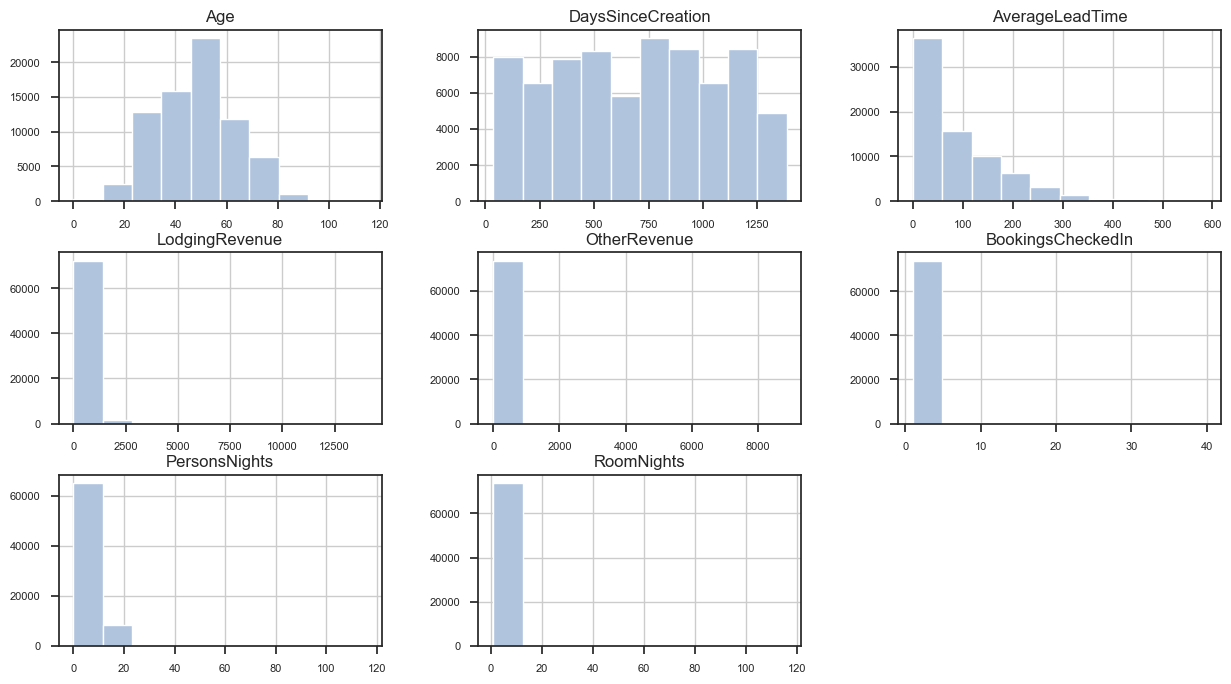

In [61]:
# HISTOGRAM (METRIC FEATURES)
# Get a depper visual understanding on metric features through histograms.

# Set layout
sns.set_theme(style = 'white', palette = None)
sns.set_style("ticks",{'axes.grid' : False})

n_col = 3
n_row = math.ceil(df[metric_features].shape[1]/n_col)
df[metric_features].hist(bins=10, 
                         figsize=(15, df[metric_features].shape[1]), 
                         layout=(n_row, n_col), 
                         xlabelsize=8, ylabelsize=8,
                         color ='lightsteelblue'
                         );

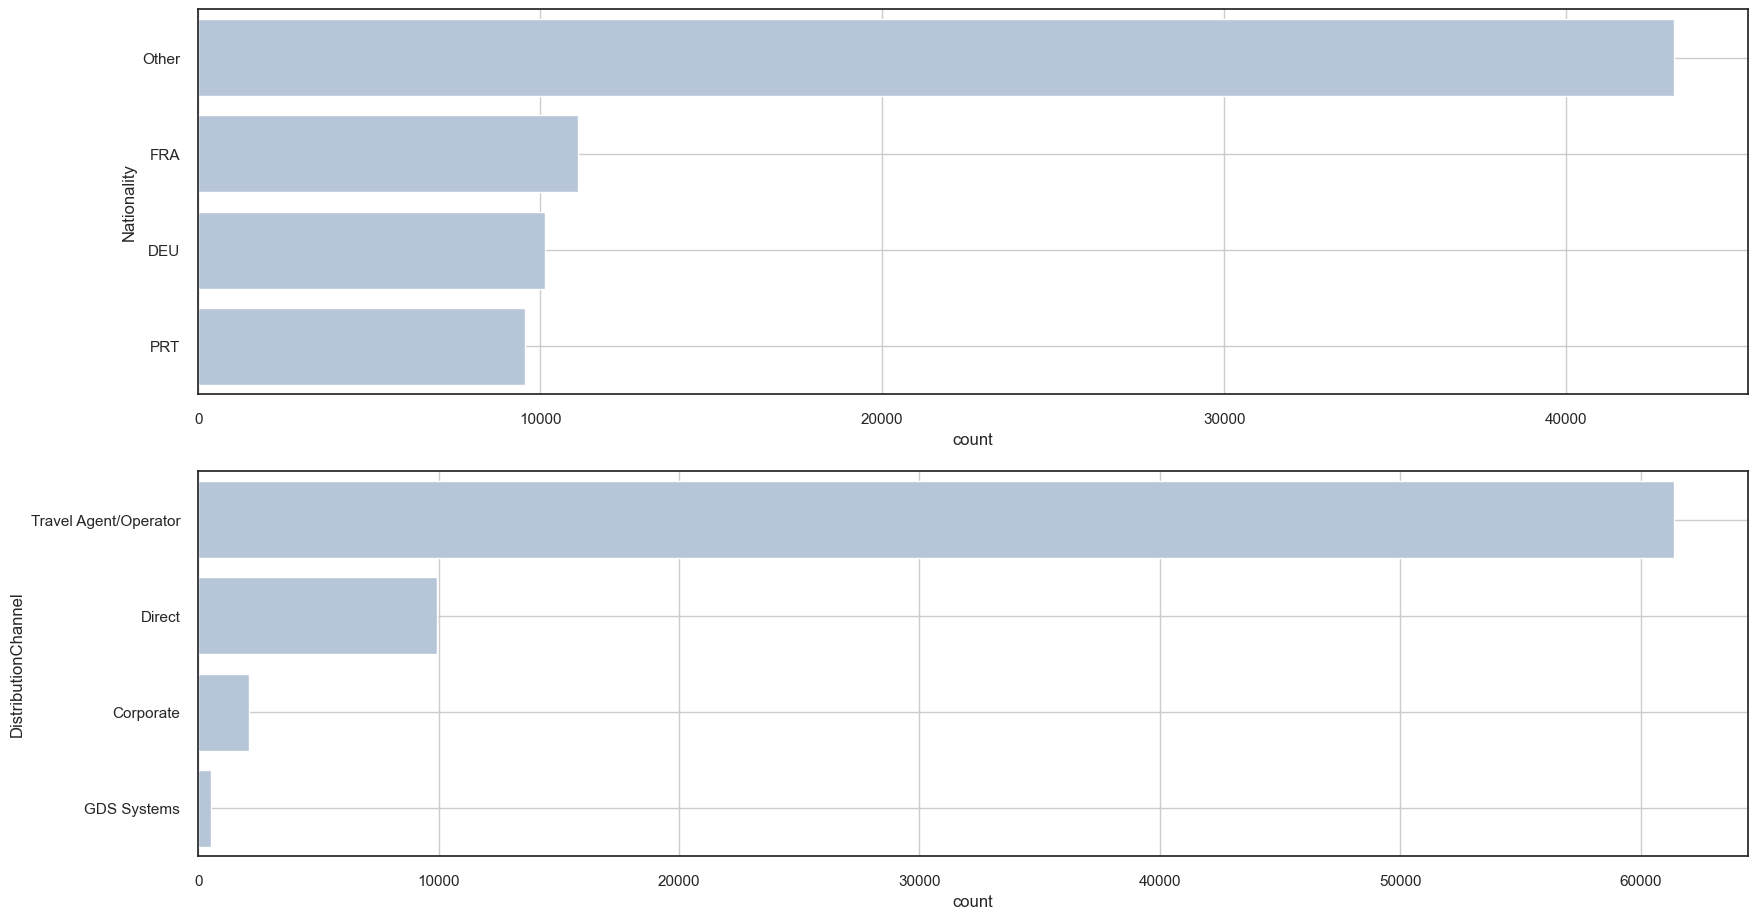

In [62]:
# Get a depper visual understanding on 'CATEGORICAL FEATURES' through histograms.

# All Non-Metric Variables' Absolute Frequencies
sns.set()
sns.set_theme(style = 'white', palette = None)

# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(2, ceil(len(categorical_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each bar plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), categorical_features): 
    sns.countplot(y=df[feat].astype(object), ax=ax, color='#b0c4de', order = df[feat].value_counts().index)
    ax.grid(True)

# Layout
title = "Categorical Variables' Absolute Frequencies"
plt.show()

- **3.2) Cleaning data**
- 3.2.4) Boxplots Analysis
- 3.2.4.1) Manual Removal

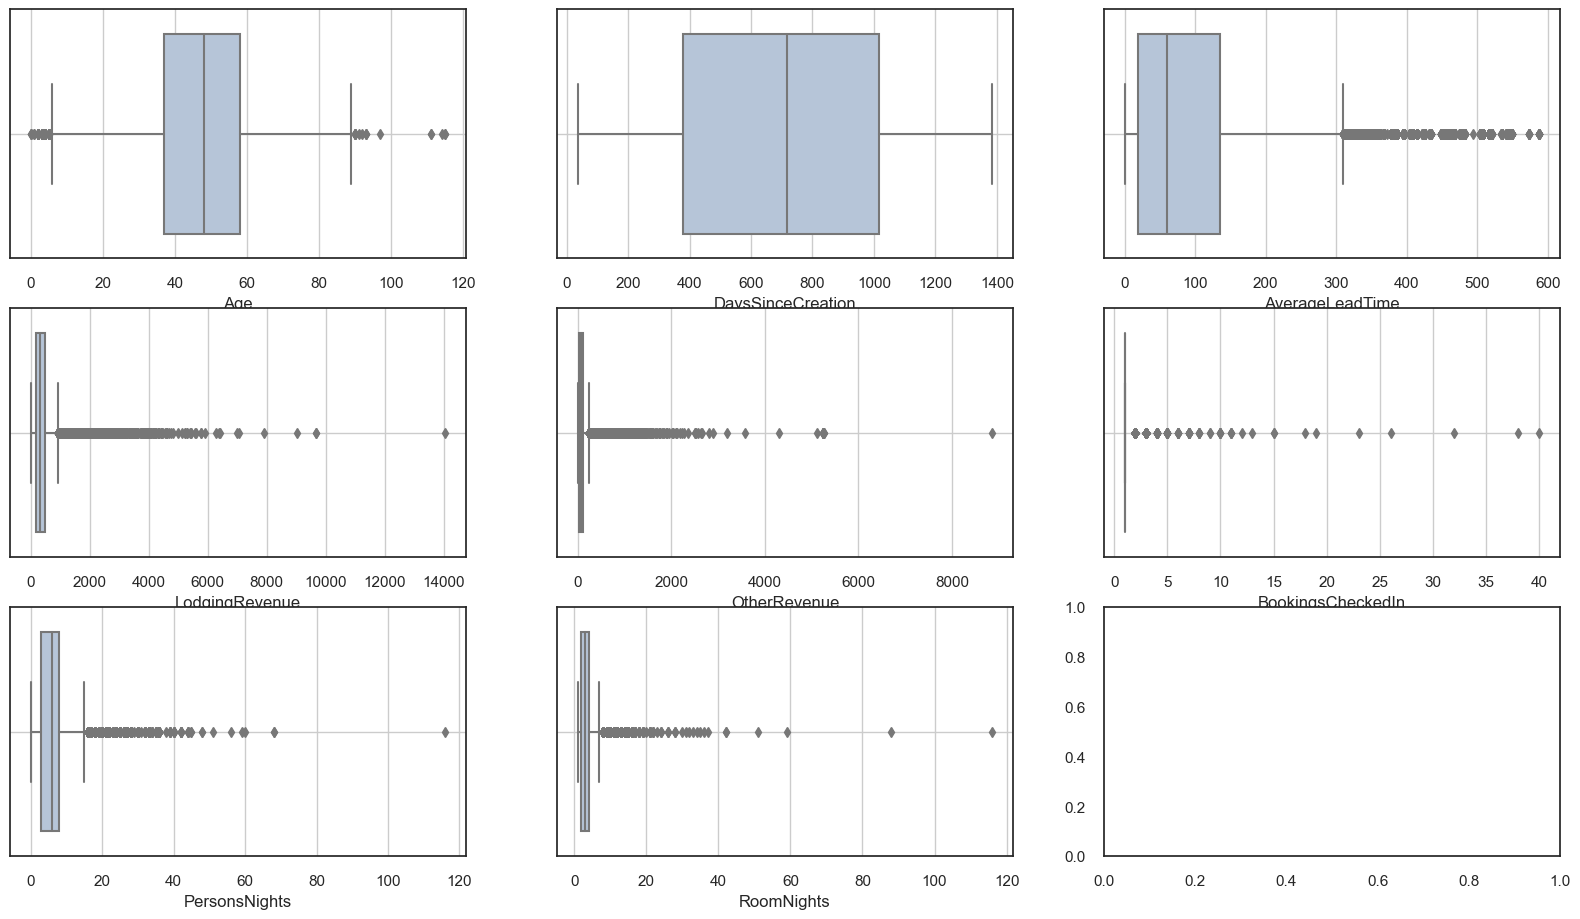

In [63]:
# Get a depper visual understanding on METRIC FEATURES through Box Plots. 
# With this graph, we can have an even better understanding on existing outliers.

# All Metric Variables' Box Plots in one figure.
sns.set()
sns.set_theme(style = 'white', palette = None)

# Prepare figure. Create indvidual axes where each box plot will be placed.
fig, axes = plt.subplots(3, 3, figsize=(20, 11))

# Plot data.
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): 
    sns.boxplot(x=df[feat], ax=ax, color ='lightsteelblue')
    # Customize
    ax.grid(True)
    
# Layout
title = "Metric Variables Box Plots" # Add a centered title to the figure
plt.show()

In [64]:
# Outlier Manual Removal (First method).
    # Here, on outliers manual remotion, we decided to look both at the histograms, at the box plots and at the 
    # descriptive statistics resume.
    # In our opinion, all these three were relevant instruments to filter each variable.
        # So, based on these elements, we mostly adopted a 'try and error aproach'.

filters_1 = (
     (df['Age']<=90) # Mostly, by looking at the boxplots. The expected living age in 2018 in Portugal was 80, which is in accordance with our threshold defined.
     &
     (df['AverageLeadTime']<=(365))  # Mostly, by looking at the boxplots. We defined one year gap for our threshold.
     &    
     (df['LodgingRevenue']<=(6000)) # Mostly, by looking at the boxplots and the histograms.
     &
     (df['OtherRevenue']<=(2000)) # Mostly, by looking at the boxplots and the histograms. This represents one third of Lodging Revenue.
     &
     (df['BookingsCheckedIn']<=(5)) # Since the current year of the database is 2016.
     &
     (df['PersonsNights']<=(40)) # Mostly, by looking at the boxplots.
     &
     (df['RoomNights']<=(30)) # Mostly, by looking at the boxplots.
)

df_manual_removal = df[filters_1]

print('Percentage of data kept after removing outliers in df_1:', np.round(df_manual_removal.shape[0] / df_original.shape[0], 4))

Percentage of data kept after removing outliers in df_1: 0.6517


- **3.2) Cleaning data**
- 3.2.4) Boxplots Analysis
- 3.2.4.2) IQR Removal

In [65]:
# Make another copy

df_IQR_removal = df.copy()

In [66]:
# Source: We were not able to identify the source, although we did not create the code. 
# We obtained the code from Machine Learning classes. 

def check_IQR_outliers(data, criterion, mode='data'):
    '''
    Detects outliers by generating a decision range based on a criterion (threshold)
    and locating values that don't fall within this range.
    Can return the dataframe without the outliers or the percentage of remaining data
    after outlier removal or the values considered as outliers for each column by
    changing the parameter 'mode' (data as default)

    Args:
        data (pandas.core.frame.DataFrame) : set of data
        col (pandas.core.series.Series) : column of the data to check outliers
        criterion (int) : IQR multiplier, the higher, the larger the decision range
        mode (str): 'data' to get dataframe without outliers 'perc' to check percentage
                     or 'values' to check values

    Returns:
        Dataframe without
        Print with percentage of remaining data after removing outliers or
        index and values that fall outside the decision range (outliers)
    '''
    if mode == 'data':
        Q1 = data.quantile(.25) # value of first quartile
        Q3 = data.quantile(.75) # value of third quartile
        IQR = Q3 - Q1 # interquartile range
        lower_lim = Q1 - criterion * IQR # setting min limit
        upper_lim = Q3 + criterion * IQR # setting max limit

        outliers = []
        for col in data.select_dtypes(np.number).columns:
            llim = lower_lim[col]
            ulim = upper_lim[col]
            outliers.append(data[col].between(llim, ulim, inclusive='both'))

        # np.all() tests whether all array elements along a given axis evaluate to True
        outliers = data[np.all(outliers, 0)]

        return outliers

    elif mode == 'perc':
        print('\n\033[1mPercentage of remaining data after outlier removal with IQR method:\033[0m\n')
        Q1 = data.quantile(.25) # value of first quartile
        Q3 = data.quantile(.75) # value of third quartile
        IQR = Q3 - Q1 # interquartile range
        lower_lim = Q1 - criterion * IQR # setting min limit
        upper_lim = Q3 + criterion * IQR # setting max limit

        outliers = []
        for col in data.select_dtypes(np.number).columns:
            #outliers.append(data[col].between(lower_lim[col], upper_lim[col], inclusive='both'))
            llim = lower_lim[col]
            ulim = upper_lim[col]
            outliers.append(data[col].between(llim, ulim, inclusive='both'))

        # np.all() tests whether all array elements along a given axis evaluate to True
        outliers = data[np.all(outliers, axis=0)]

        print(f'\033[1m{round(len(outliers)/len(data)*100,3)} %\033[0m of remaining data',
              'after IQR method outlier removal, when criterion is', criterion)

    else:
        print('\n\n\033[1mOutlier Values:\033[0m\n')
        for col in data.select_dtypes(np.number).columns:
            Q1 = data[col].quantile(.25) # value of first quartile
            Q3 = data[col].quantile(.75) # value of third quartile
            IQR = Q3 - Q1 # interquartile range
            lower_lim = Q1 - criterion * IQR # setting min limit
            upper_lim = Q3 + criterion * IQR # setting max limit
            outliers = data.loc[(data[col] > upper_lim) | (data[col] < lower_lim)][col]
            print(f'Outlier values in \033[1m{col}\033[0m:\n')
            for idx, val in outliers.items():
                print(f'Value from Client {idx}: \033[1m', round(val,2),'\033[0m\n')

In [67]:
# Checking percentage of remaining data
check_IQR_outliers(data=df_IQR_removal, criterion=3, mode='perc')

print('Percentage of data kept after removing outliers in df_1:', 
      np.round(df_IQR_removal.shape[0] / df_original.shape[0], 4))


Percentage of remaining data after outlier removal with IQR method:

72.696 % of remaining data after IQR method outlier removal, when criterion is 3
Percentage of data kept after removing outliers in df_1: 0.6621


**Key Takeawyays**
- As we verified above, the IQR method, do not remove any value at all from our dataset.
- Since under the manual approach, we have more accuracy on the data we are removing, we opted for that approach.

In [68]:
# Integrate the created 'df_manual_removal' dataframe into our main dataframe. 

df = df_manual_removal.copy()

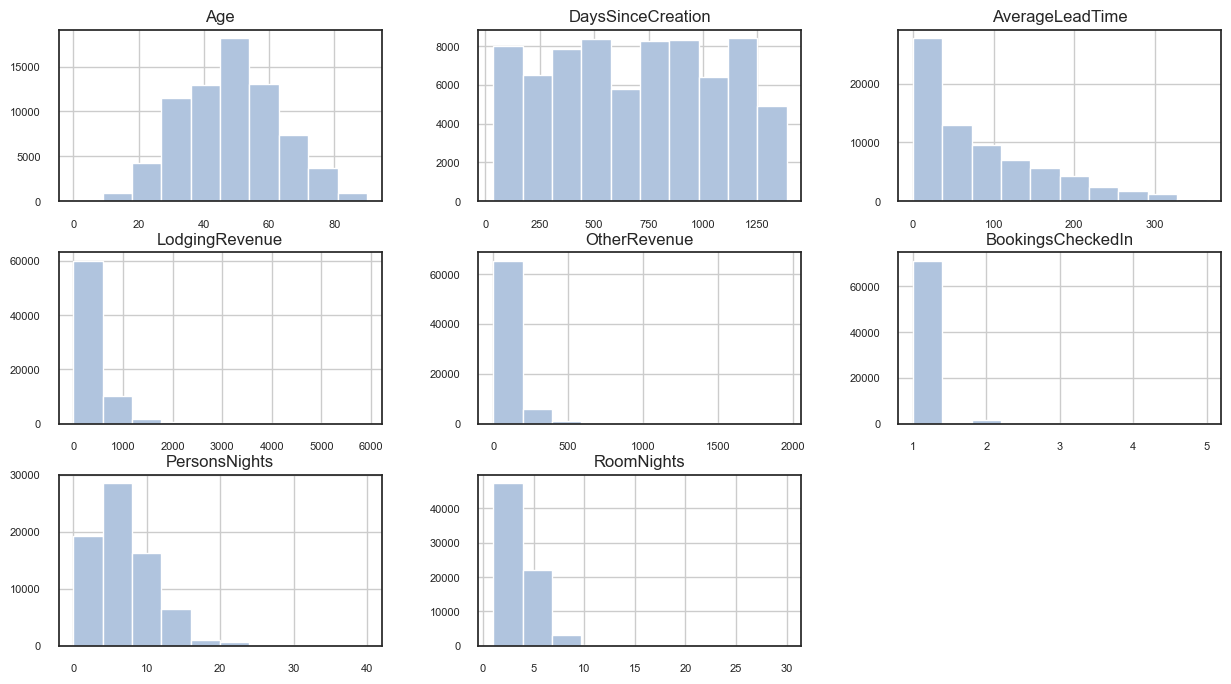

In [69]:
# Check the histograms and boxplots after outlier removal and outlier replacement.

# Set layout
sns.set_theme(style = 'white', palette = None)

n_col = 3
n_row = math.ceil(df[metric_features].shape[1]/n_col)
df[metric_features].hist(bins=10, 
                         figsize=(15, df[metric_features].shape[1]), 
                         layout=(n_row, n_col), 
                         xlabelsize=8, ylabelsize=8,
                         color ='lightsteelblue'
                         );

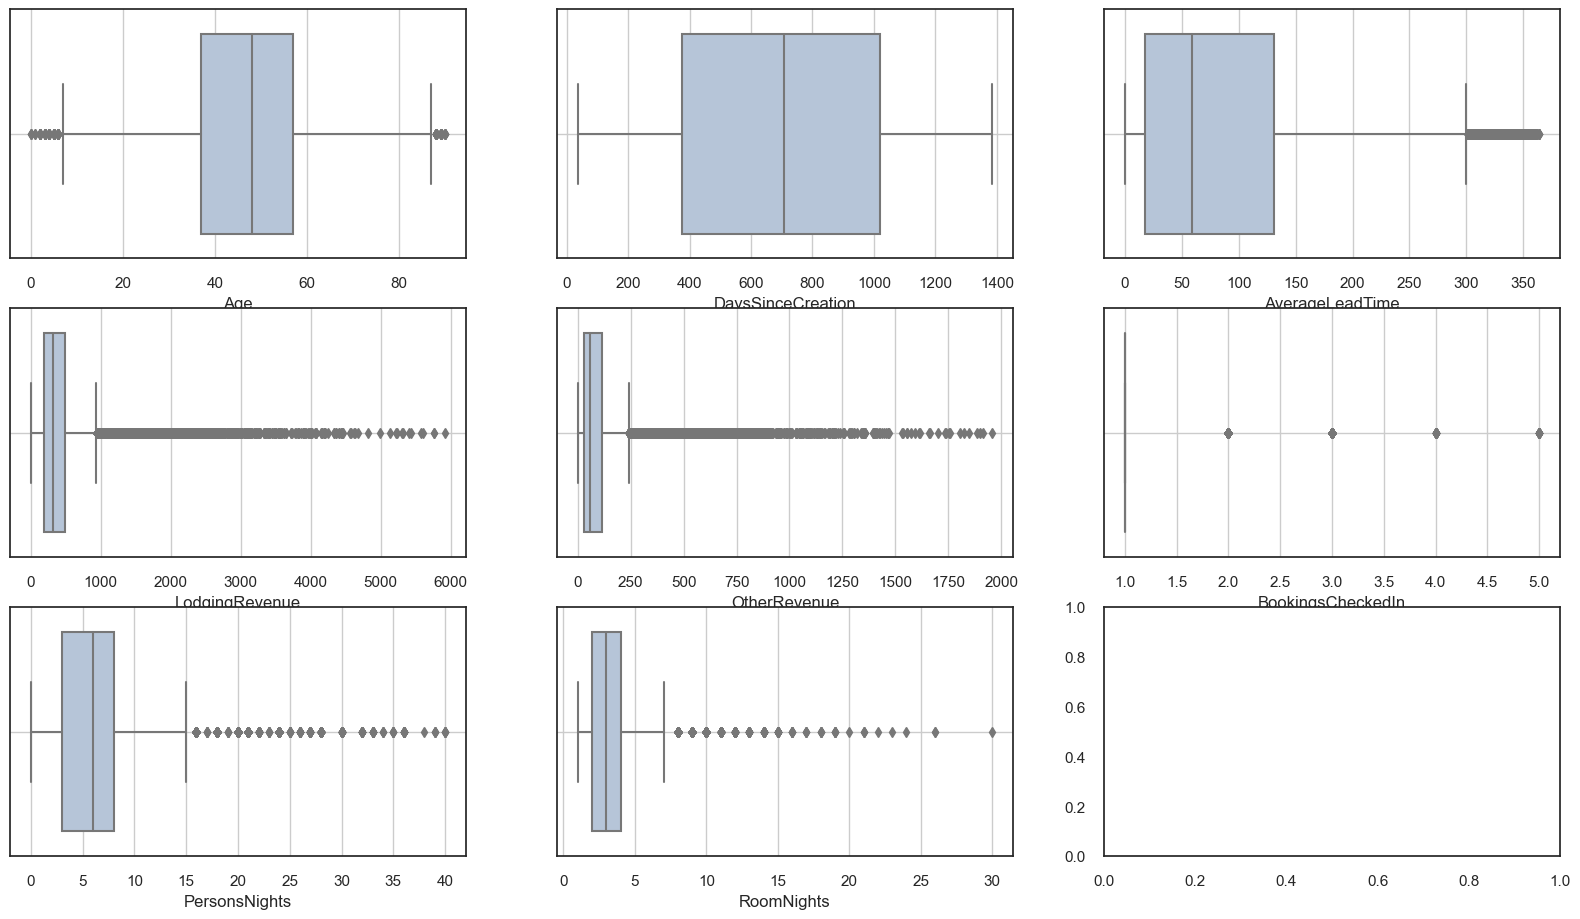

In [70]:
# Get a depper visual understanding on METRIC FEATURES through Box Plots. 
# With this graph, we can have an even better understanding on existing outliers.

# All Metric Variables' Box Plots in one figure.
sns.set()
sns.set_theme(style = 'white', palette = None)

# Prepare figure. Create indvidual axes where each box plot will be placed.
fig, axes = plt.subplots(3, 3, figsize=(20, 11))

# Plot data.
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): 
    sns.boxplot(x=df[feat], ax=ax, color ='lightsteelblue')
    # Customize
    ax.grid(True)
    
# Layout
title = "Metric Variables Box Plots" # Add a centered title to the figure
plt.show()

- **3.2) Cleaning data**
- 3.2.5) Correlations Analysis

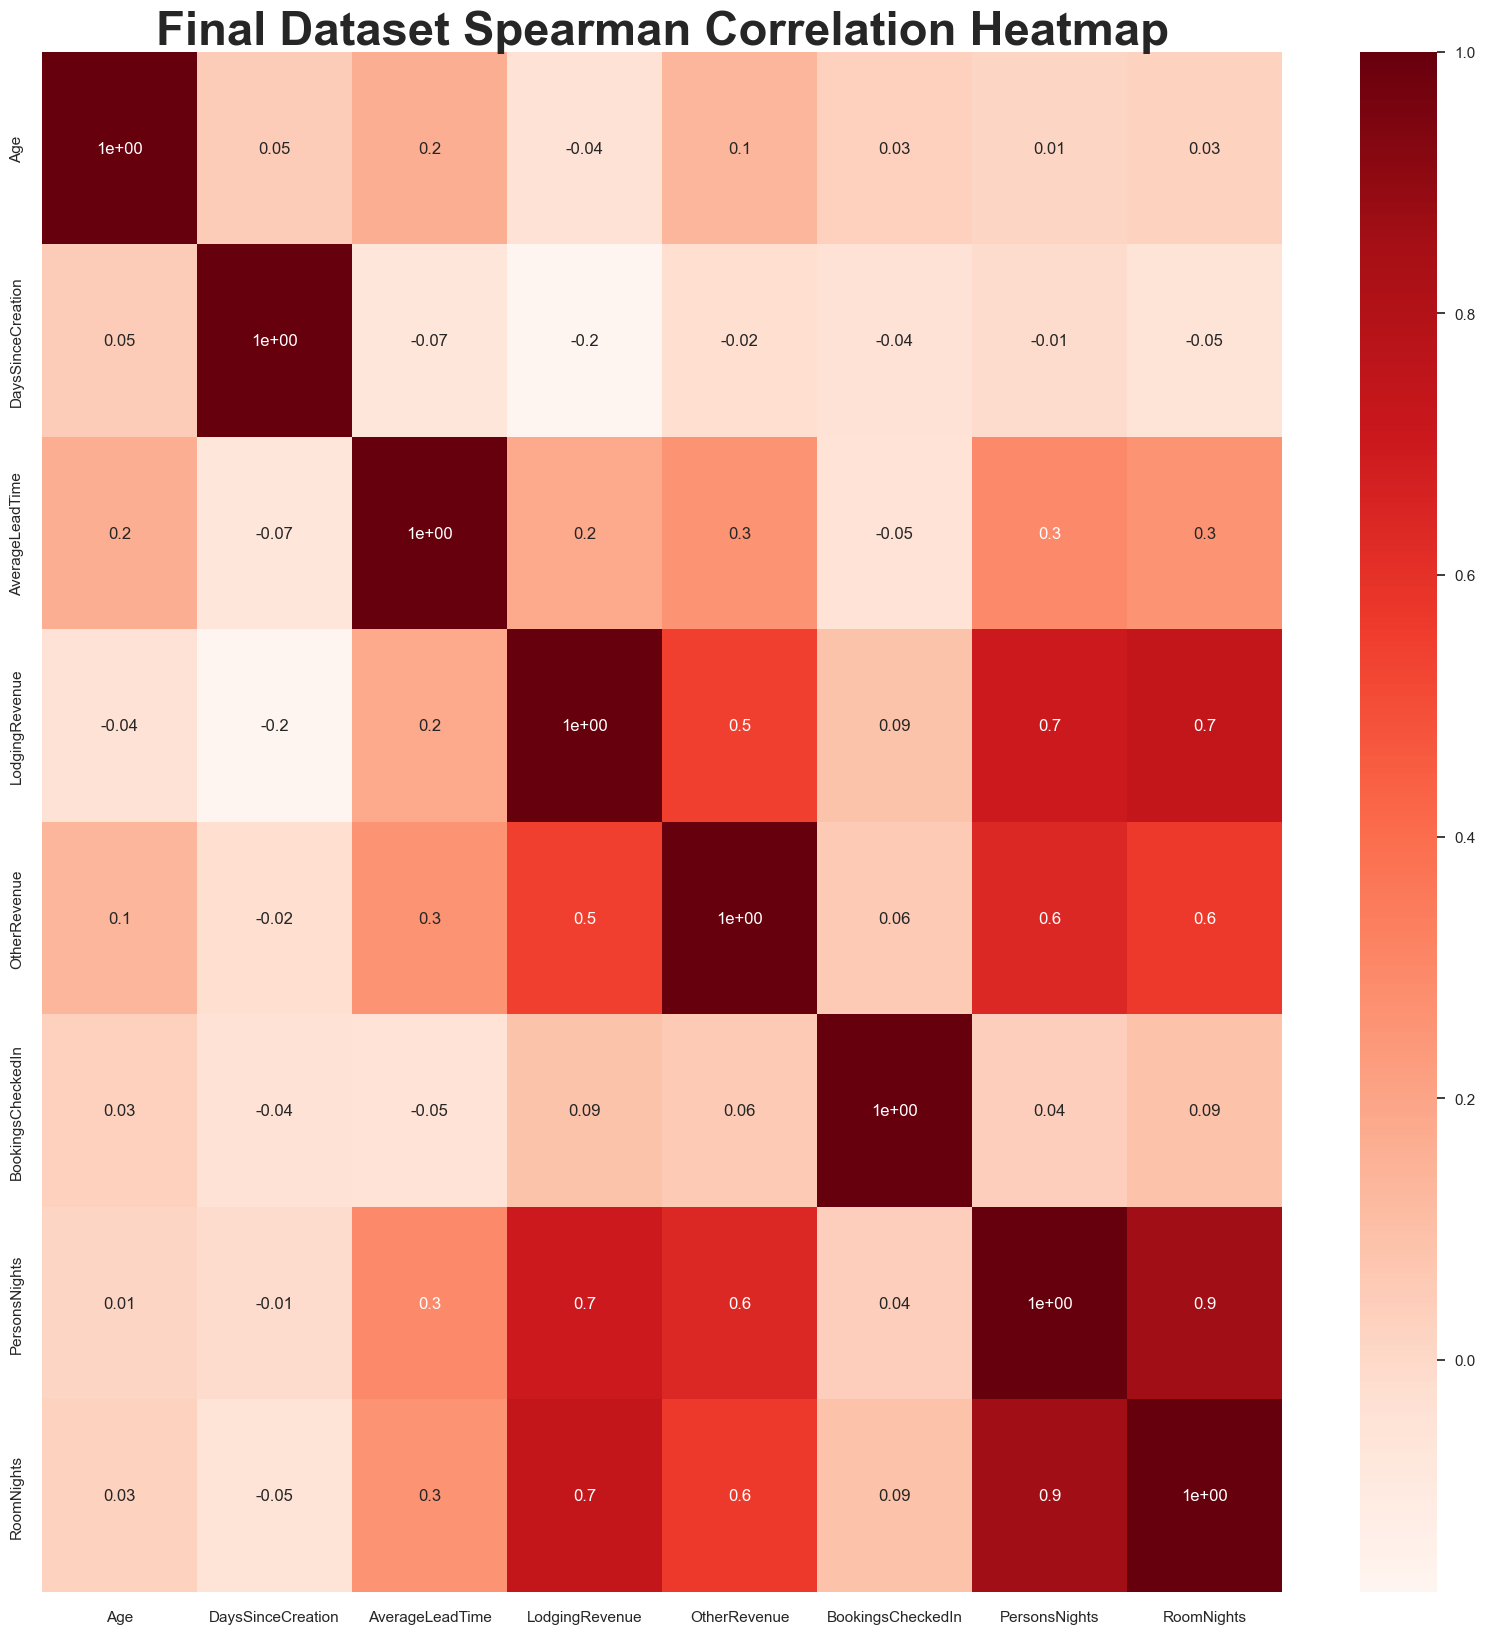

In [71]:
# Define the correlation function.

def cor_heatmap(cor):
    plt.figure(figsize=(20,20))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.title('Final Dataset Spearman Correlation Heatmap',fontsize = 34, fontweight = 'bold')
    plt.show()
    
# Apply the correlation method to my dataset, usins spearman.

cor_spearman = df[metric_features].corr(method= 'spearman')
cor_heatmap(cor_spearman)

- **3.2) Cleaning data**
- 3.2.6) Removing unnecessary features from section 3.2

In [72]:
# RELEVANCY APPROACH
# Under this approach, we already dropped three features: ID, NameHash and DocIDHash on section 3.1.
# We decided, under relevancy approach, to keep all the remaining variables for now.

In [73]:
# REDUNDANCY APPROACH
# From observing the variable above, we decided to remove variables that are totally correlation and
# does not bring new information for our future conclusions.
# In this sense, we decided to remove:
    # RoomNight, since we could more conclusions from PersonNights (corr = 1) 
    # Other Revenue, since its highly correlated with 5 other variables and LodgingRevenue a bigger amount of money.
    
df.drop(columns=['RoomNights'], inplace=True)
metric_features.remove('RoomNights')
df.head(1)

,Nationality,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCheckedIn,PersonsNights,DistributionChannel,SRKingSizeBed,SRTwinBed,SRQuietRoom
0,PRT,52,440,59,292.0,82.3,2,6,Corporate,0,0,0


- **3.3) Construct data**
- 3.3.1) Creating new variables

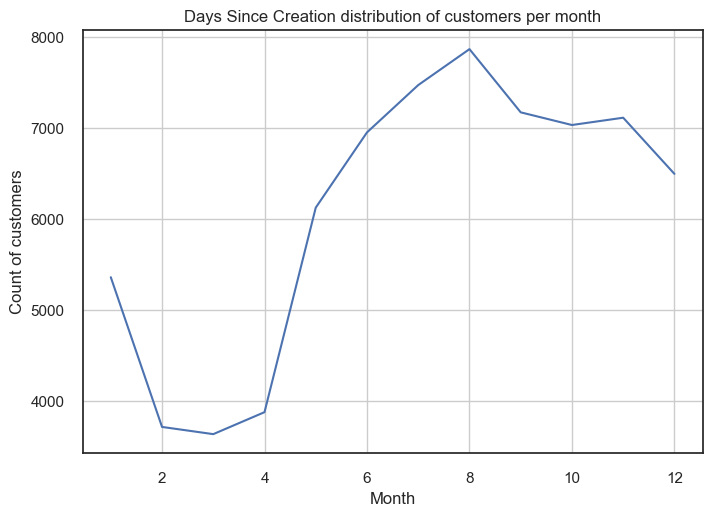

In [74]:
# LODGING REVENUE: accomodation expenses (main ones).
# OTHER REVENUE: other expenses (food and so on).
df["Total_revenue"]=df["LodgingRevenue"]+df["OtherRevenue"]

# Creating month function:
def month(variable):
    y=(parser.parse("Dec 31 2018")-timedelta(days=variable)).month
    return y

# Creating date function:
def date(variable):
    y=(parser.parse("Dec 31 2018")-timedelta(days=variable)).strftime("%A")
    return y

# Creating year function:
def year(variable):
    y = (parser.parse("Dec 31 2018")-timedelta(days=variable)).year
    return y


# Drawing a graph of the distribution per month
number_customers_month=(df['DaysSinceCreation'].apply(month)).value_counts()
sns.lineplot(number_customers_month.index,number_customers_month.values)
plt.xlabel('Month')
plt.ylabel('Count of customers')
plt.title('Days Since Creation distribution of customers per month')
plt.grid()

# As we can see below, the majority of the customers, visits the hotel in the summer, specially in August.
# This makes sense, since Portugal´s whether is very appealing during that period of the year.

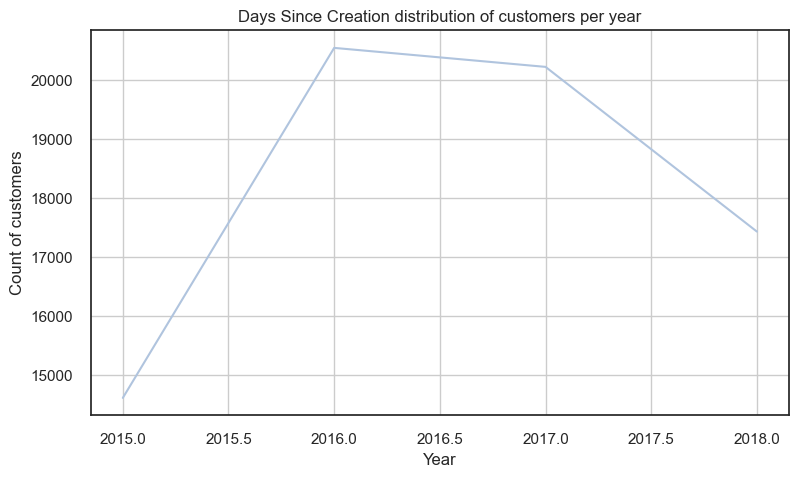

In [75]:
# There was a peak in 2016, revealing a record in the number of costumers since the creation of the database.
# The numbers present a decreasing tendency, from then, which highlights the relevancy of this project.

# Drawing a graph of the distribution per year
number_customers_year=(df['DaysSinceCreation'].apply(year)).value_counts()
number_customers_year

# Drawing a graph of the distribution per month
plt.figure(figsize=(9,5))
sns.lineplot(number_customers_year.index,number_customers_year.values, color = 'lightsteelblue')
plt.xlabel('Year')
plt.ylabel('Count of customers')
plt.title('Days Since Creation distribution of customers per year')
plt.grid()

In [76]:
# AvgRevenueperYear: average of revenue per year for each costumer
df['AvgRevenueperYear']= (df['Total_revenue']*365/df['DaysSinceCreation'])

# Create a variable Revenueperbooking: average of total revenue per room per book
df['Revenueperbooking']=df['Total_revenue']/df['BookingsCheckedIn']

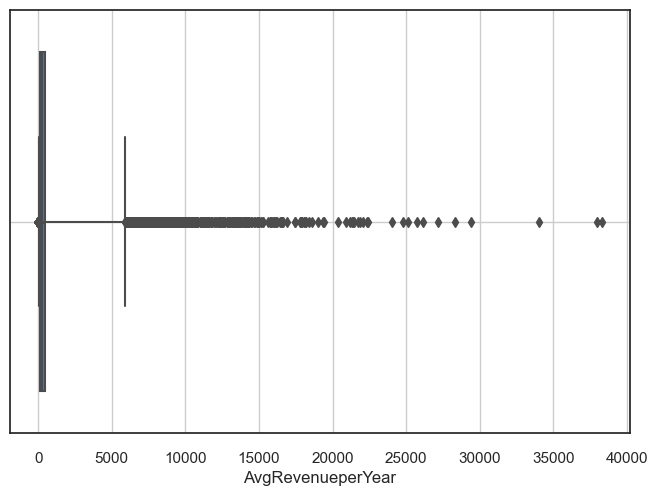

In [77]:
# Revenueperroomnight

sns.boxplot(x = df['AvgRevenueperYear'], orient='h', whis=[1,99])

# Customize
plt.grid()

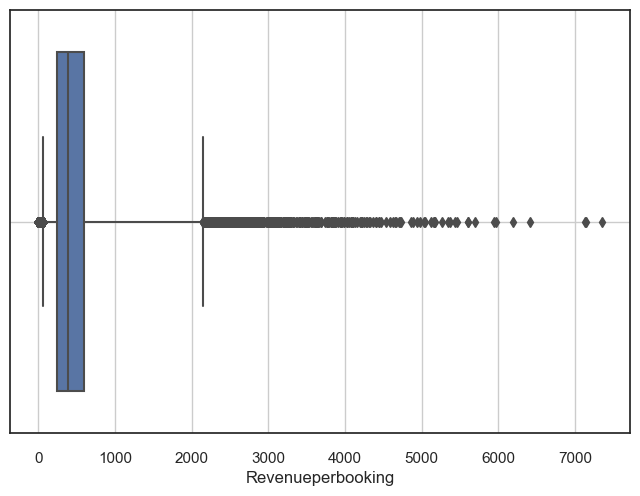

In [78]:
# Revenueperroomnight

sns.boxplot(x = df['Revenueperbooking'], orient='h', whis=[1,99])

# Customize
plt.grid()

In [79]:
# Outlier Manual Removal (First method).
    # Here, on outliers manual remotion, we decided to look both at the histograms, at the box plots and at the 
    # descriptive statistics resume.
    # In our opinion, all these three were relevant instruments to filter each variable.
        # So, based on these elements, we mostly adopted a 'try and error aproach'.

filters_2 = (
     (df['AvgRevenueperYear']<=30000) # Mostly, by looking at the boxplots.
     &    
     (df['Revenueperbooking']<=(6000)) # Mostly, by looking at the boxplots.
)

df_outliers_2 = df[filters_2]

print('Percentage of data kept after removing outliers in df_outliers_2:', np.round(df_outliers_2.shape[0] / df_original.shape[0], 4))

Percentage of data kept after removing outliers in df_outliers_2: 0.6517


In [80]:
# Integrate the created 'df_outliers_2' dataframe into our main dataframe. 

df = df_outliers_2.copy(deep=True)

In [81]:
# Creating a age_gap function.

def age_gap(x):
    if x<20:
        return '<20'
    elif x>=20 and x<=30:
        return '20-30'
    elif x>=31 and x<=40:
        return '31-40'
    elif x>=41 and x<=50:
        return '41-50'
    elif x>=51 and x<=60:
        return '51-60'
    else:
        return '60+'
    
# Applying to column Age.   
df['Age_gap']=df['Age'].apply(age_gap)
df

,Nationality,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCheckedIn,PersonsNights,DistributionChannel,SRKingSizeBed,SRTwinBed,SRQuietRoom,Total_revenue,AvgRevenueperYear,Revenueperbooking,Age_gap
0,PRT,52,440,59,292.00,82.3,2,6,Corporate,0,0,0,374.30,310.498864,187.15,51-60
1,PRT,48,1385,61,280.00,53.0,1,10,Travel Agent/Operator,0,0,0,333.00,87.758123,333.00,41-50
3,FRA,61,1385,93,240.00,60.0,1,10,Travel Agent/Operator,0,0,0,300.00,79.061372,300.00,60+
5,Other,55,1385,58,230.00,24.0,1,4,Travel Agent/Operator,0,0,0,254.00,66.938628,254.00,51-60
7,FRA,33,1385,38,535.00,94.0,1,10,Travel Agent/Operator,1,0,0,629.00,165.765343,629.00,31-40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111724,Other,60,37,43,875.00,167.8,1,10,Travel Agent/Operator,0,1,0,1042.80,10287.081081,1042.80,51-60
111726,PRT,51,37,7,173.55,18.0,1,1,Direct,0,0,1,191.55,1889.614865,191.55,51-60
111727,DEU,34,36,41,98.00,14.0,1,2,Travel Agent/Operator,1,0,0,112.00,1135.555556,112.00,31-40
111729,Other,43,36,170,755.25,20.0,1,10,Travel Agent/Operator,1,0,0,775.25,7860.173611,775.25,41-50


In [82]:
# Per year, the age gaps that have the most revenue are ages 51-60 and 60+
# Per booking, the age gaps that make the most revenue are ages 41-50 and 51-60

df.groupby('Age_gap')['AvgRevenueperYear', 'Revenueperbooking'].sum()

,AvgRevenueperYear,Revenueperbooking
Age_gap,,
20-30,6.016751e+06,4.215943e+06
31-40,6.824128e+06,6.186154e+06
41-50,1.017139e+07,9.077642e+06
51-60,8.835185e+06,8.172351e+06
60+,7.661190e+06,6.609524e+06
<20,1.865500e+06,1.209239e+06


In [83]:
# For corporate distribution channel, most of the clientes are 41-50, as is for the other channels.

pd.crosstab(df['Age_gap'], df['DistributionChannel'])

DistributionChannel,Corporate,Direct,GDS Systems,Travel Agent/Operator
Age_gap,,,,
20-30,173,1071,56,7107
31-40,392,1995,144,11172
41-50,798,3067,200,14810
51-60,430,2101,114,13483
60+,260,1396,23,12545
<20,8,285,1,1181


In [84]:
# For Average Lead Time, the highest value is from customers aged 60+
# For Days Since Creation the highest value comes from customers aged 31-40

df.groupby('Age_gap')['DaysSinceCreation', 'AverageLeadTime'].sum()

,DaysSinceCreation,AverageLeadTime
Age_gap,,
20-30,5286148,597080
31-40,9357763,918271
41-50,13527295,1416316
51-60,11382205,1403641
60+,9892178,1620683
<20,910801,148616


- **3.3) Construct data**
- 3.3.2) Removing unnecessary features from section 3.3

In [85]:
# Here, we also decided to eliminate all the features that have a total revenue equal to 0. 
# This customers do not represent a relevant target for our project, in out opinion.
# Here, are deleting around 30% of our original dataset.

df.drop(columns=['LodgingRevenue', 'OtherRevenue'], inplace=True)

In [86]:
df.drop(columns=['Age', 'PersonsNights', 'BookingsCheckedIn', 'Total_revenue', 'DaysSinceCreation'], inplace=True)
metric_features.remove('Age')
metric_features.remove('PersonsNights')
metric_features.remove('BookingsCheckedIn')
metric_features.remove('DaysSinceCreation')
metric_features.remove('LodgingRevenue')
metric_features.remove('OtherRevenue')
df.head(2)

,Nationality,AverageLeadTime,DistributionChannel,SRKingSizeBed,SRTwinBed,SRQuietRoom,AvgRevenueperYear,Revenueperbooking,Age_gap
0,PRT,59,Corporate,0,0,0,310.498864,187.15,51-60
1,PRT,61,Travel Agent/Operator,0,0,0,87.758123,333.00,41-50


- **3.3) Construct data**
- 3.3.3) Rechecking Correlations Analysis

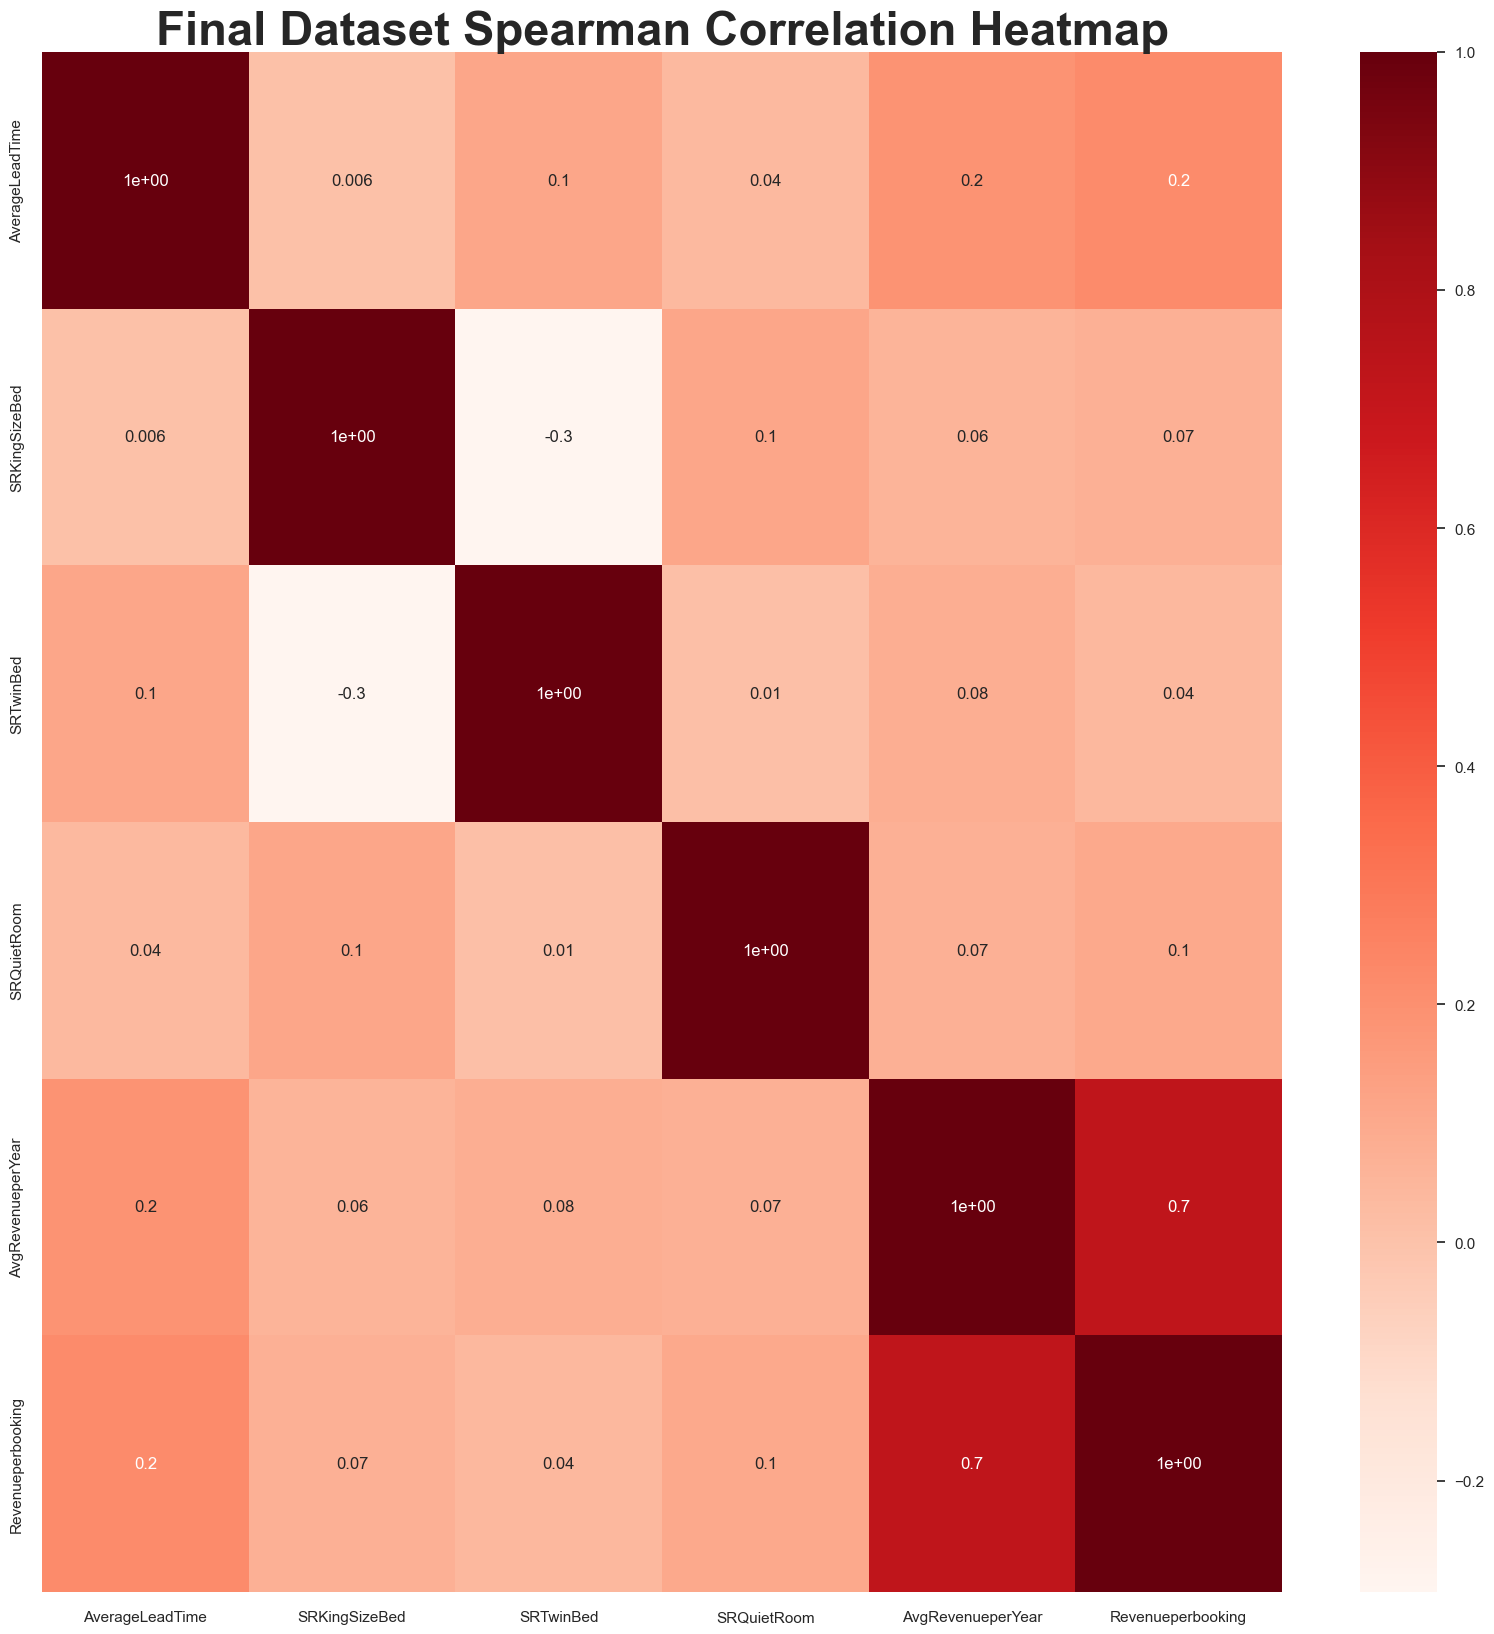

In [87]:
# Apply the correlation method to my dataset, usins spearman.

cor_spearman = df.corr(method= 'spearman')
cor_heatmap(cor_spearman)

- **3.3) Construct data**
- 3.3.4) OHE

In [88]:
# Applying One Hot Encoding to CATEGORICAL features.

df_ohe = ce.OneHotEncoder(cols = ['Nationality',
                                  'DistributionChannel', 
                                  'Age_gap'], use_cat_names=True)
df_ohe = df_ohe.fit_transform(df)
df_ohe.dtypes

Nationality_PRT                                int64
Nationality_FRA                                int64
Nationality_Other                              int64
Nationality_DEU                                int64
AverageLeadTime                                int64
DistributionChannel_Corporate                  int64
DistributionChannel_Travel Agent/Operator      int64
DistributionChannel_Direct                     int64
DistributionChannel_GDS Systems                int64
SRKingSizeBed                                  int64
SRTwinBed                                      int64
SRQuietRoom                                    int64
AvgRevenueperYear                            float64
Revenueperbooking                            float64
Age_gap_51-60                                  int64
Age_gap_41-50                                  int64
Age_gap_60+                                    int64
Age_gap_31-40                                  int64
Age_gap_20-30                                 

- **3.4) Integrate/merge data**

In [89]:
# Integrate the created 'df_ohe' dataframe into our main dataframe. 

df = df_ohe.copy(deep=True)

- **3.5) Format data**
- 3.5.1) Normalizing data

In [90]:
# Use 'MinMaxScaler' to scale the data. 
# Although we also tried 'StandardScaler', we have obtained better results with 'MinMaxScaler'.
# Make another security copy of our dataset before normalization.
df_before_scaling = df.copy(deep=True)

# Normalizing all columns.
cols = list(df.columns) # Save the name of the columns
df_array = df.values # Returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(df_array)
df = pd.DataFrame(df_scaled, columns=cols)
df

,Nationality_PRT,Nationality_FRA,Nationality_Other,Nationality_DEU,AverageLeadTime,DistributionChannel_Corporate,DistributionChannel_Travel Agent/Operator,DistributionChannel_Direct,DistributionChannel_GDS Systems,SRKingSizeBed,SRTwinBed,SRQuietRoom,AvgRevenueperYear,Revenueperbooking,Age_gap_51-60,Age_gap_41-50,Age_gap_60+,Age_gap_31-40,Age_gap_20-30,Age_gap_<20
0,1.0,0.0,0.0,0.0,0.162088,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010562,0.031465,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.167582,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.002985,0.055987,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.255495,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.002689,0.050439,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.159341,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.002277,0.042705,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.104396,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.005639,0.105753,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72807,0.0,0.0,1.0,0.0,0.118132,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.349934,0.175325,1.0,0.0,0.0,0.0,0.0,0.0
72808,1.0,0.0,0.0,0.0,0.019231,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.064279,0.032205,1.0,0.0,0.0,0.0,0.0,0.0
72809,0.0,0.0,0.0,1.0,0.112637,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.038628,0.018830,0.0,0.0,0.0,1.0,0.0,0.0
72810,0.0,0.0,1.0,0.0,0.467033,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.267379,0.130342,0.0,1.0,0.0,0.0,0.0,0.0


- **3.5) Format data**
- 3.5.2) PCA

In [91]:
# Make a third security copy of our dataset before applying principal components.

df_before_pca = df.copy(deep=True)

In [92]:
# Creating a new variable and fitting the PCA algorithm with our Data.
df_pca = PCA().fit(df)

# Showing the percentage explained (in %) by each component and the cumulative sum (in %) of this percentage on a table.
# We can check a total of 20 components.
df_pca_df = pd.DataFrame({"Explained var. (%)":np.round(df_pca.explained_variance_ratio_*100, decimals = 1),
                          "Cumulative var. (%)":np.round(np.cumsum(df_pca.explained_variance_ratio_*100), decimals = 2)})
df_pca_df.index.name = 'Principal Components'
df_pca_df.index += 1 

print (df_pca_df)

                      Explained var. (%)  Cumulative var. (%)
Principal Components                                         
1                                   15.3                15.27
2                                   13.1                28.38
3                                   11.6                40.01
4                                   10.5                50.48
5                                    9.5                59.98
6                                    8.6                68.61
7                                    6.5                75.13
8                                    5.8                80.95
9                                    5.5                86.40
10                                   4.6                91.00
11                                   3.5                94.48
12                                   2.0                96.46
13                                   1.8                98.21
14                                   1.1                99.30
15      

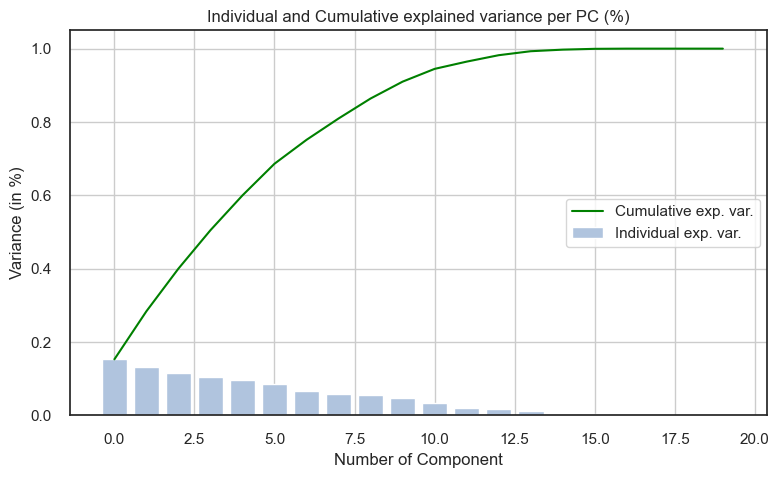

In [93]:
# Plotting the Cumulative Sum of the Explained Variance.
plt.figure(figsize=(9,5))

plt.plot(np.cumsum(df_pca.explained_variance_ratio_), 
         color = 'green', 
         label = 'Cumulative exp. var.')

x_pos = np.arange(len(df_pca.explained_variance_ratio_))
plt.bar(x_pos,df_pca.explained_variance_ratio_,        
        label = 'Individual exp. var.',
        color = 'lightsteelblue')

# Graph details.
plt.xlabel('Number of Component')
plt.ylabel('Variance (in %)') # For each component
plt.title('Individual and Cumulative explained variance per PC (%)')
plt.legend(loc = 'center right', frameon = True)
plt.grid()
plt.show()

In [94]:
# Reducing the dimensions of the data with PCA.
# Define the numbers of components as 11, since it represents around 95% of our dataset variation
n_PC = 11
pca_final = PCA(n_components = n_PC) 
pca_final.fit(df)
df_pca_final = pca_final.transform(df) 
df_pca_final = pd.DataFrame(df_pca_final) 
df_pca_final.columns = ['PC' + str(x) for x in range(1,n_PC + 1)] 
  
df_pca_final.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
0,0.801408,0.402731,-0.322711,0.779443,-0.483803,0.111979,-0.420692,0.129042,-0.809541,-0.066131,0.031422
1,0.881743,0.265914,0.508584,-0.535616,-0.311774,-0.186759,-0.332253,0.090380,-0.585947,-0.167667,0.043601
2,0.627032,-0.516457,-0.467085,-0.306682,0.370452,0.355062,0.775313,-0.343822,-0.254557,-0.307296,-0.009723
3,-0.467982,0.031443,-0.440687,0.302752,-0.726065,-0.142254,-0.014283,-0.107662,-0.185448,-0.302302,-0.036147
4,0.379006,-0.785847,0.423957,0.495139,0.729047,-0.607808,0.446619,-0.315229,0.034249,0.111126,-0.170684


**Key Takeaways**
- From the table above, we understand that 11 components explain around 95% of the variation in the dataset. <br>
- In order to get an additional confort on data, we choose 11 components as our threshold.

# **4. Modeling**


- **4.1) Selecting modeling techniques**
- 4.1.1) KMeans
- **4.2) Generate test design**
- 4.2.1) Inertia
- 4.2.2) Sillhouete Coefficient
- **4.3) Build model**
- 4.3.1) Final Clustering Solution
- **4.4) Assess model**
- 4.4.1) Assessing using R2
- 4.4.2) Interpreting Clustering Algorithms

- **4.2) Generate test design**
- 4.2.1) Inertia

In [95]:
# Define the range of our clustering analysis.
range_clusters = range(1, 11)

# For loop for inertia. 
# Inertia measures how well a dataset was clustered. Lower values of inertia means better results.

inertia = []
for n_clus in range_clusters:  # Iterate over desired ncluster range (defined in the cell above).
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df_pca_final)
    inertia.append(kmclust.inertia_)

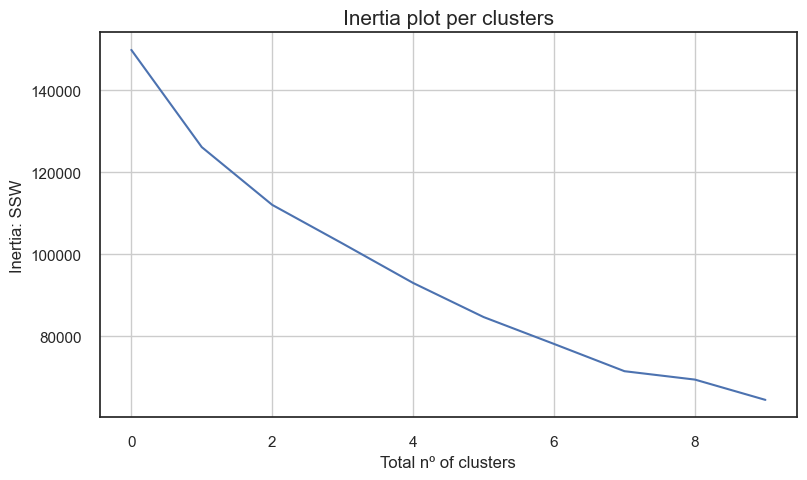

In [96]:
# By observing the elbow method, we should opt for a value between 4 and 6 clusters.
# We opted for defined the number of clusters as 6.
    
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
plt.ylabel("Inertia: SSW")
plt.xlabel("Total nº of clusters")
plt.title("Inertia plot per clusters", size=15)
plt.grid()
plt.show()

- **4.2) Generate test design**
- 4.2.2) Sillhouete Coefficient

For n_clusters = 2, the average silhouette_score is : 0.17507309629769807
For n_clusters = 3, the average silhouette_score is : 0.18594046664238062
For n_clusters = 4, the average silhouette_score is : 0.1820440730647783
For n_clusters = 5, the average silhouette_score is : 0.26378019111324685
For n_clusters = 6, the average silhouette_score is : 0.26589860280776834
For n_clusters = 7, the average silhouette_score is : 0.25172907966186303
For n_clusters = 8, the average silhouette_score is : 0.2541870485353268
For n_clusters = 9, the average silhouette_score is : 0.27518928441910395
For n_clusters = 10, the average silhouette_score is : 0.2700578580925786


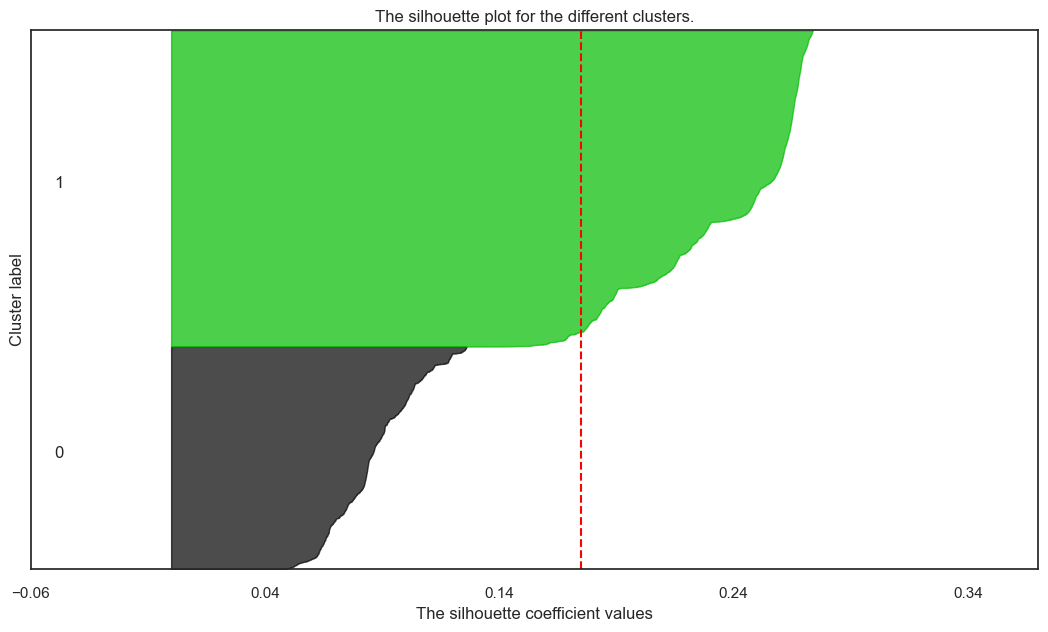

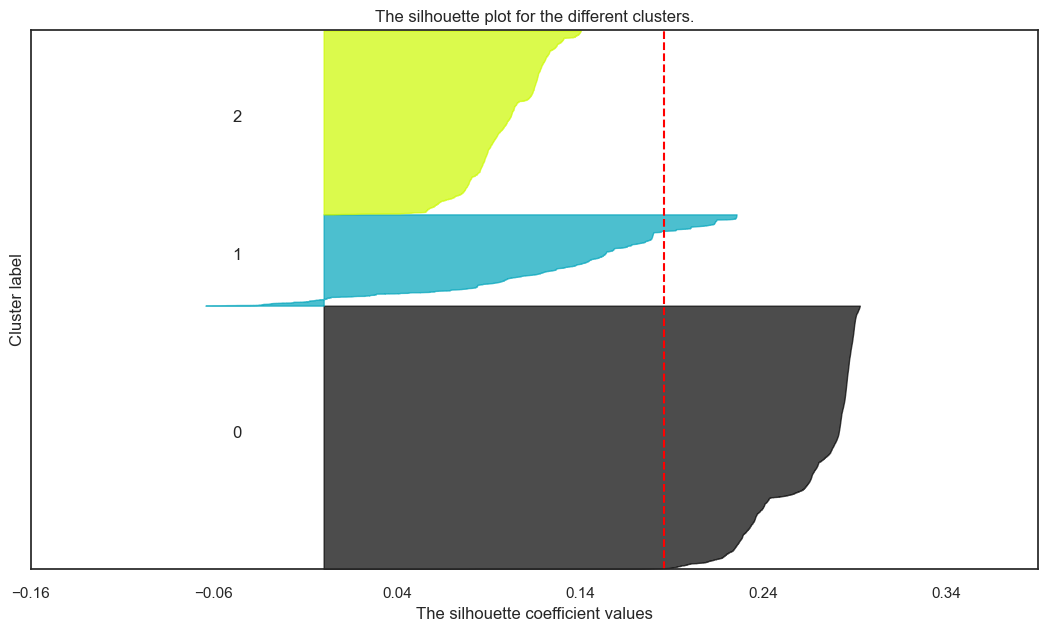

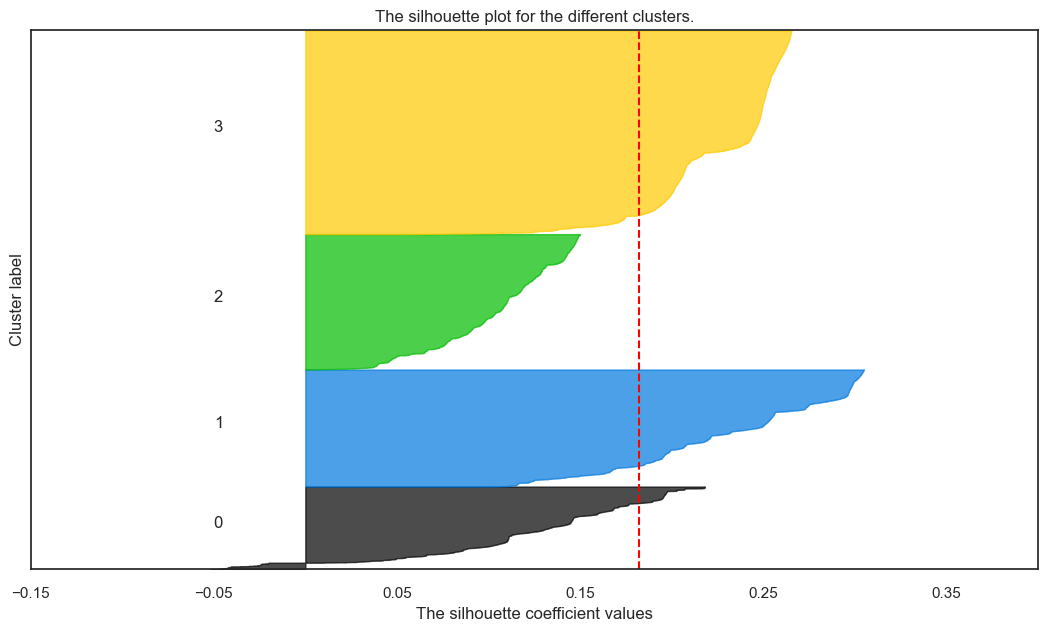

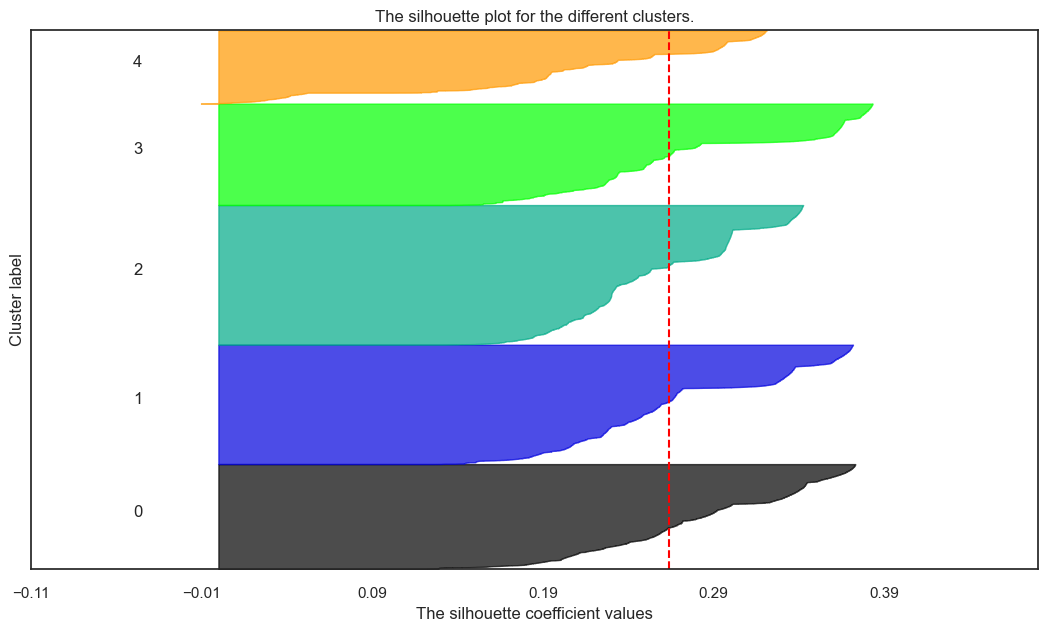

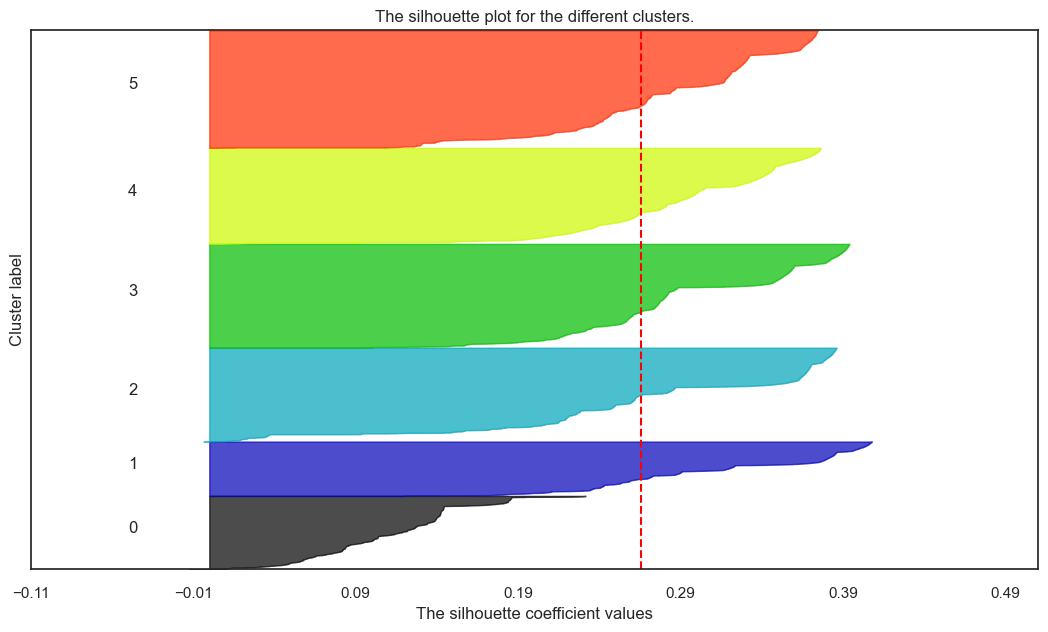

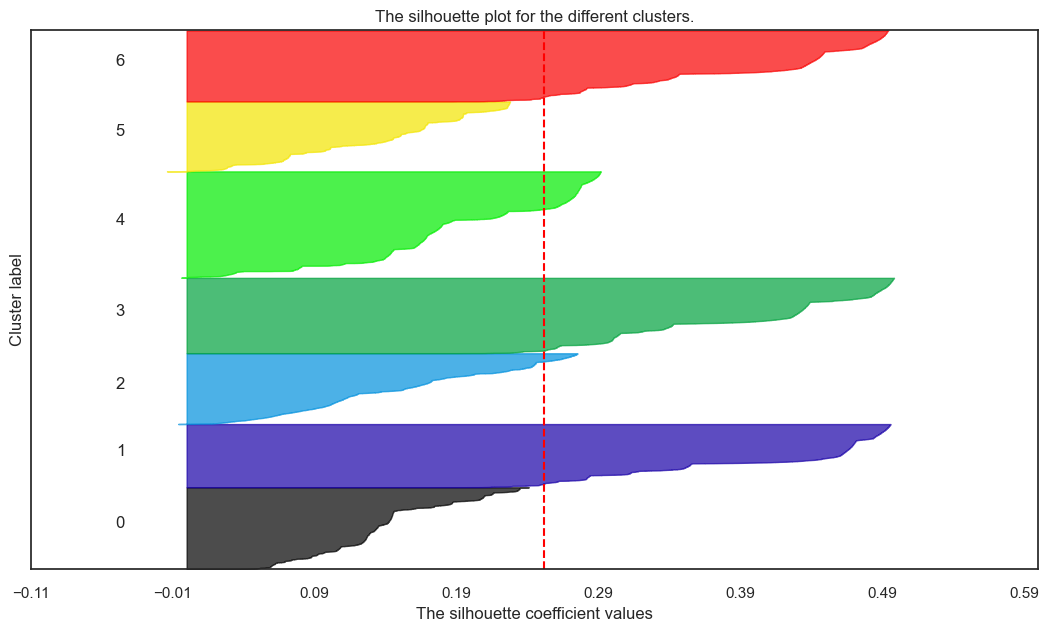

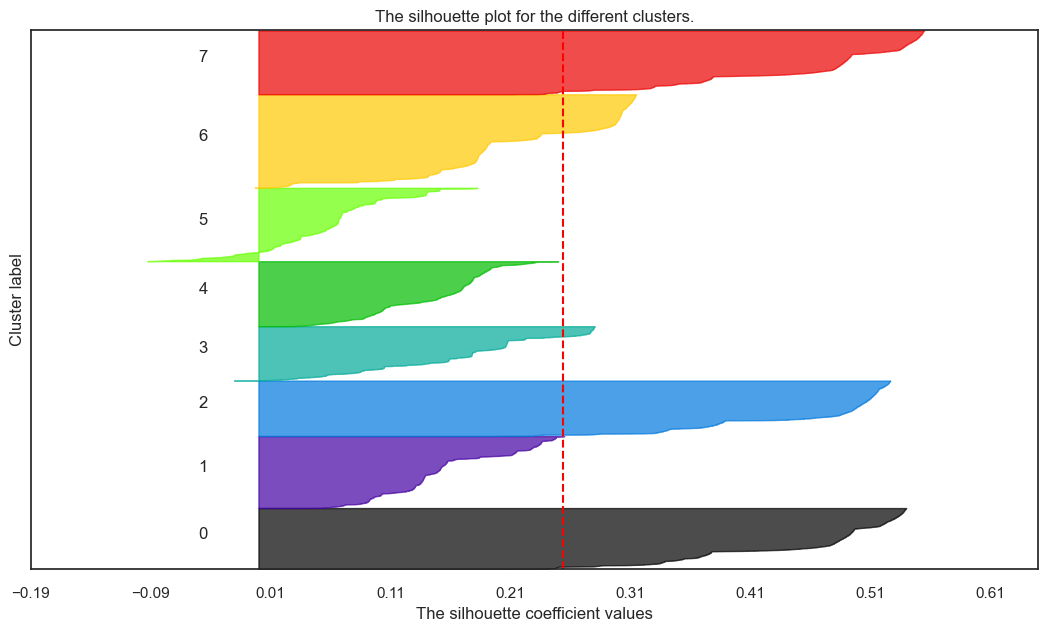

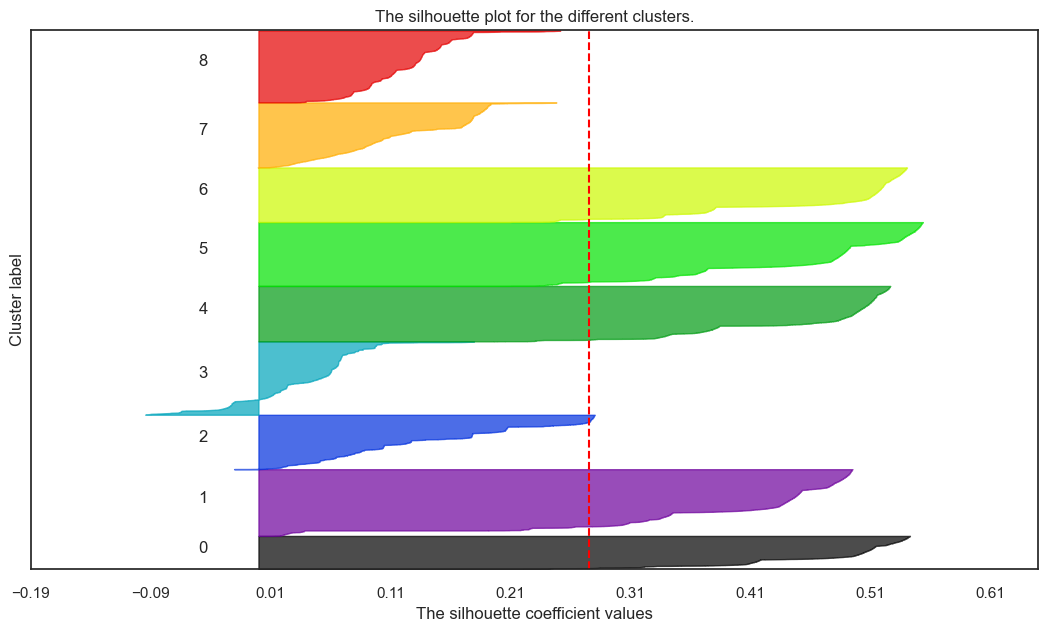

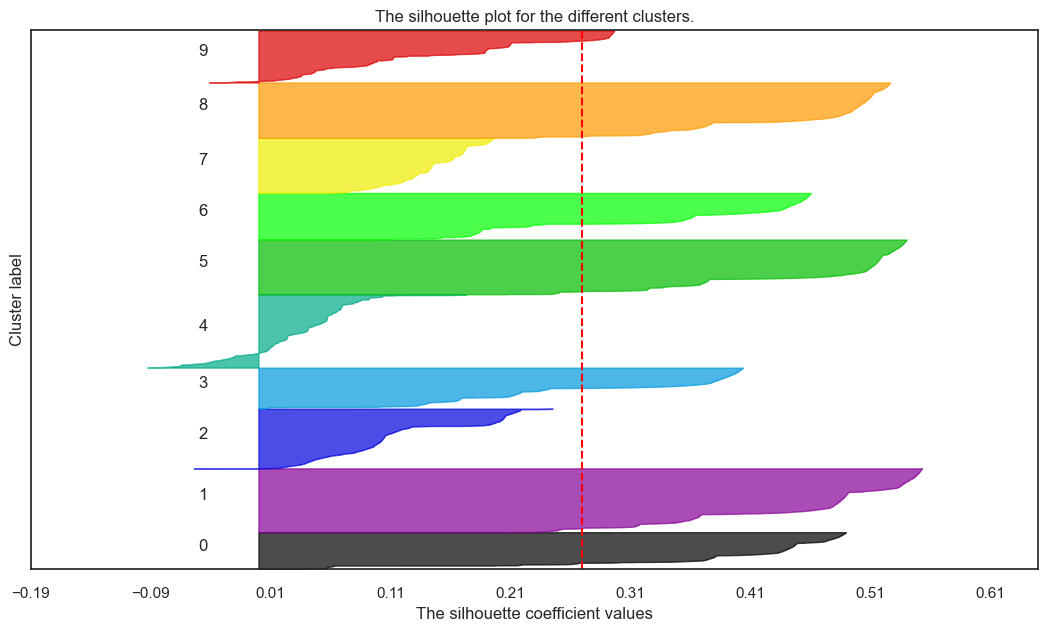

In [97]:
# Select 'K' number of clusters based on the Silhouette method.
# BE CAREFUL! Depending on the computer machine this cell can take a lot of time to run!

# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

# Store average silhouette metric.
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df, cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the different clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

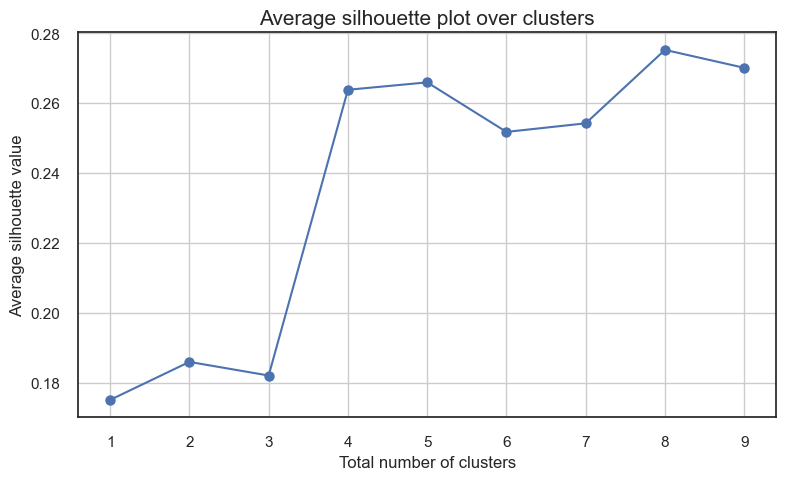

In [98]:
# Draw the average silhouette plot.

plt.figure(figsize=(9,5))
plt.plot(range(1,10), avg_silhouette, marker=".", markersize=15)
plt.ylabel("Average silhouette value")
plt.xlabel("Total number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.grid()
plt.show()

- **Observations from Inertia:**
    - By analyzing Inertia graphing, under "Elbow Method", we get to the conclusion that the ideal number of clusters is 5, as long as it presents the lower SSW.
    
    
- **Observations from Silhouette:**    
    - Silhouette, initially increases from 3 to 4 clusters; 
    - However, from 4 to 5/6, the Silhouette has the a slightly decrease in the value, although not very significant. 
    - Then, from 7 on, it increases again until around 9, meaning that on average, our observations are better representated with this a higher number of clusters than with smaller ones.
    - Exclusively under Silhouette approach, we conclude that 8 is the ideal number of clusters.
    
    
- **Inertia vs Silhouette:**
    - Our goal is to achieve a small inertia value and a high silhouete value.
    - After discussing, we believe that for marketing purposes, it may be easier to implement and it would produce similar benefits, if we define a smaller amount of clusters.
    - In this sense, we opted to follow Inertia conclusions, adopting 5 clusters as our final solution, since that for marketing purposes it is not good to have many customer segmentation.

- **4.3) Build model**
- 4.3.1) Final Clustering Solution

In [99]:
# # Our Final cluster solution.

# number_clusters = 6
# kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=42)
# df_km_labels = kmclust.fit_predict(df)
# df_km_n_clusters = len(np.unique(df_km_labels))
# print("Number of estimated kmeans clusters : %d" % df_km_n_clusters)

# Our Final cluster solution.

number_clusters = 5
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=42)
allDistances = kmclust.fit_transform(df_pca_final)
df_km_labels = kmclust.predict(df_pca_final)
df_km_n_clusters = len(np.unique(df_km_labels))

print("Number of estimated kmeans clusters is: %d" % df_km_n_clusters)

Number of estimated kmeans clusters is: 5


In [100]:
# Characterize the final clusters (after Scalling).

df_kmeans = pd.concat((df, pd.Series(df_km_labels, index=df.index, name='df_km_labels')), axis=1)
df_kmeans_mean = df_kmeans.groupby('df_km_labels').mean()


# Characterize the final clusters (before Scalling).

df_before_scaling_kmeans = pd.concat((df_before_scaling, pd.Series(df_km_labels, index=df_before_scaling.index, name='df_km_labels')), axis=1)
df_before_scaling_kmeans_mean = df_before_scaling_kmeans.groupby('df_km_labels').mean()
df_before_scaling_kmeans_mean

,Nationality_PRT,Nationality_FRA,Nationality_Other,Nationality_DEU,AverageLeadTime,DistributionChannel_Corporate,DistributionChannel_Travel Agent/Operator,DistributionChannel_Direct,DistributionChannel_GDS Systems,SRKingSizeBed,SRTwinBed,SRQuietRoom,AvgRevenueperYear,Revenueperbooking,Age_gap_51-60,Age_gap_41-50,Age_gap_60+,Age_gap_31-40,Age_gap_20-30,Age_gap_<20
df_km_labels,,,,,,,,,,,,,,,,,,,,
0,0.094347,0.178096,0.623649,0.103907,74.303928,0.018288,0.838736,0.137053,0.005923,0.364817,0.179032,0.069514,789.902840,546.400206,0.0,0.000000,0.000000,0.0,0.873545,0.126455
1,0.239970,0.139649,0.536981,0.083399,74.893036,0.042332,0.783700,0.163425,0.010544,0.337076,0.120460,0.083136,538.300146,480.343114,0.0,0.995045,0.000000,0.0,0.000000,0.004955
2,0.088852,0.160466,0.594680,0.156002,87.031312,0.026662,0.836000,0.130270,0.007068,0.358507,0.126984,0.108941,547.816510,506.718206,1.0,0.000000,0.000000,0.0,0.000000,0.000000
3,0.070128,0.132611,0.583055,0.214206,114.466778,0.018071,0.883028,0.097303,0.001599,0.343967,0.201070,0.088824,549.193192,468.596399,0.0,0.000000,0.988602,0.0,0.000000,0.011398
4,0.112676,0.162957,0.623294,0.101073,67.012406,0.028607,0.815296,0.145589,0.010509,0.380793,0.129096,0.077574,498.002454,451.445220,0.0,0.000000,0.000000,1.0,0.000000,0.000000


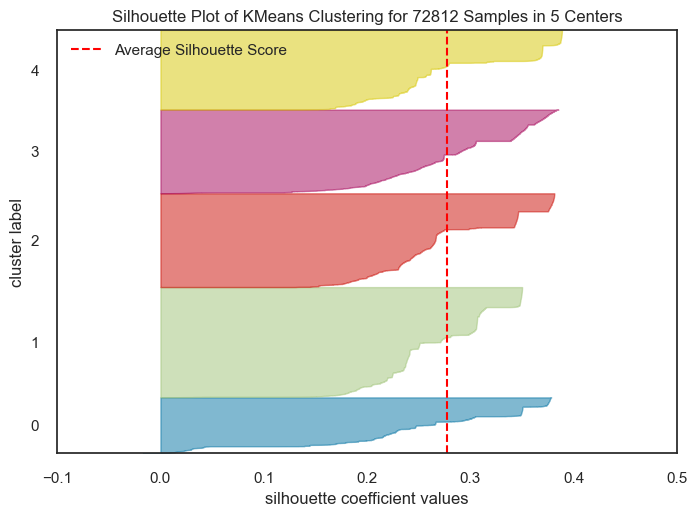

In [101]:
# Visualize Silhouette
# Source https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html

silhouette_aggregate_graph = SilhouetteVisualizer(kmclust, colors='yellowbrick')
silhouette_aggregate_graph.fit(df_pca_final)
silhouette_aggregate_graph.show()

# Customize
ax.grid(True)

In [102]:
# Final values of Inertia and Silhouete:

# WSS (Within Cluster Sum of square)
# We aim the lowest value possible. 
# This value represents the distance between each data point and its centroid.
print('Regarding Inertia, the WSS value is: {}'.format( kmclust.inertia_))

# SS (Silhouette Score)
# We aim the highest value possible.
# This score represents how similar a data point is within-cluster (cohesion) compared to other clusters (separation).
print('Regarding Silhouette, the SS value: {}'.format (silhouette_score(df_pca_final, df_km_labels, metric='euclidean')))

Regarding Inertia, the WSS value is: 93632.06896990284
Regarding Silhouette, the SS value: 0.277403657165203


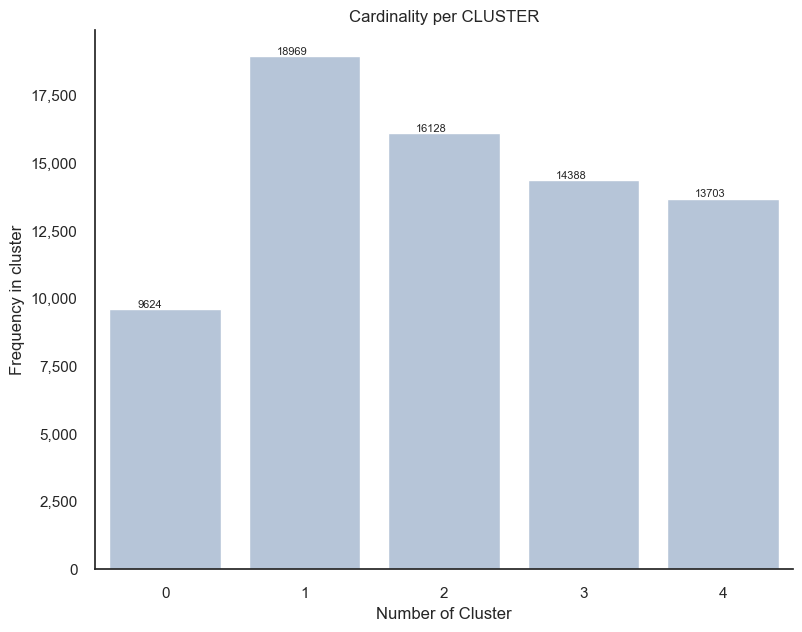

In [103]:
# Plot clusters cardinality.
# Cardinality is the number of examples per cluster. In clusters with higher cardinality, we may investigate the reason.
    # Cluster 2 has the lower cardinality.
    # Cluster 4 has the higher cardinality.

# Count observations per cluster in absolute value.
freqByCluster = df_before_scaling.groupby(df_km_labels).size()

# Draw the plot.
fig, ax = plt.subplots(figsize=(9,7))
g = sns.countplot(x=df_km_labels, color='lightsteelblue')

# Layout.
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
for index,data in enumerate(freqByCluster):
    plt.text(x=index-0.2 , y=data+50 , s=f"{data}" , fontdict=dict(fontsize=8))
sns.despine()
plt.title("Cardinality per CLUSTER", fontsize=12)
plt.xlabel("Number of Cluster")
plt.ylabel("Frequency in cluster")
plt.rc('axes', labelsize=10)

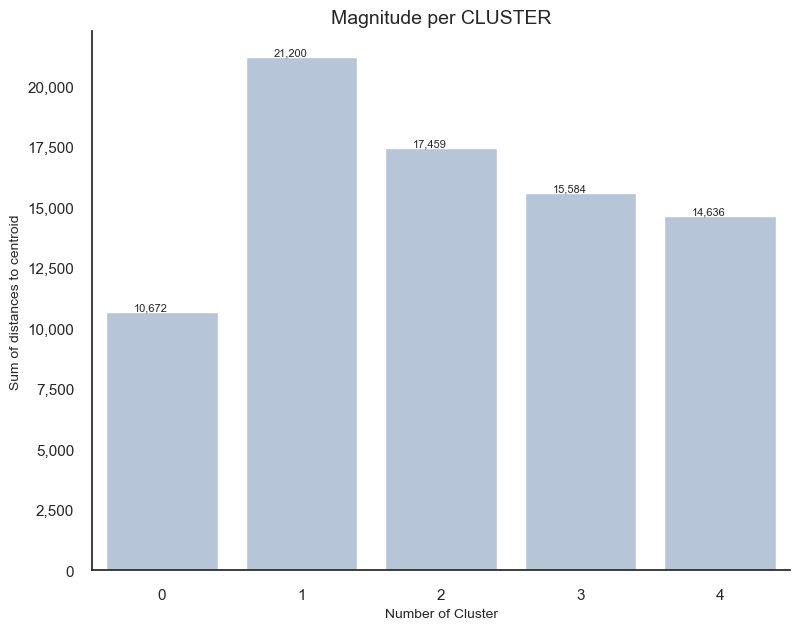

In [104]:
# Plot clusters magnitude.
# Magnitude is the sum of distances from all examples to the centroid of the cluster.
    # There is some degree of similarity among all the clusters.
    # Cluster 2 has the lower magnitude.
    # Cluster 4 has the higher magnitude.

# Compute Magnitude of each cluster.
df['distanceToCentroid'] = np.min(allDistances,axis=1)
magnitude = df['distanceToCentroid'].groupby(df_km_labels).sum()
df = df.drop(columns=['distanceToCentroid'])

# Draw the plot.
fig, ax = plt.subplots(figsize=(9,7))
g = sns.barplot(x=magnitude.index, y=magnitude.values, color='lightsteelblue')

# Layout.
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
for index,data in enumerate(magnitude):
    plt.text(x=index-0.2 , y=data+50 , s=f"{data:,.0f}" , fontdict=dict(fontsize=8))
sns.despine()
plt.title("Magnitude per CLUSTER", fontsize=14)
plt.xlabel("Number of Cluster")
plt.ylabel("Sum of distances to centroid")
plt.rc('axes', labelsize=8)

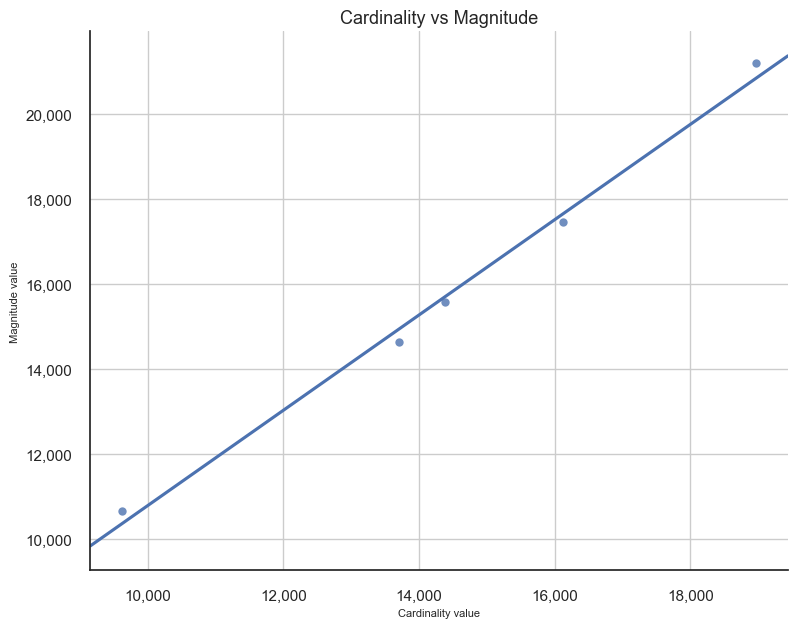

In [105]:
# Plot cardinality vs magnitude.

# As we can see below, cardinality and magnitude have a positive correlation between themselves.
# This means that clusters with a higher example of different observations, 
# must correspond to clusters with a higher total sum of distances to their centroid. 

# Draw
fig, ax = plt.subplots(figsize=(9,7))
g = sns.regplot(x=freqByCluster, y=magnitude, scatter=True, seed=123,truncate=False, ci=None)

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick)
ax.yaxis.set_major_formatter(tick)
sns.despine()
plt.title("Cardinality vs Magnitude", fontsize=13)
plt.xlabel("Cardinality value")
plt.ylabel("Magnitude value")
plt.grid()
plt.rc('axes', labelsize=11)

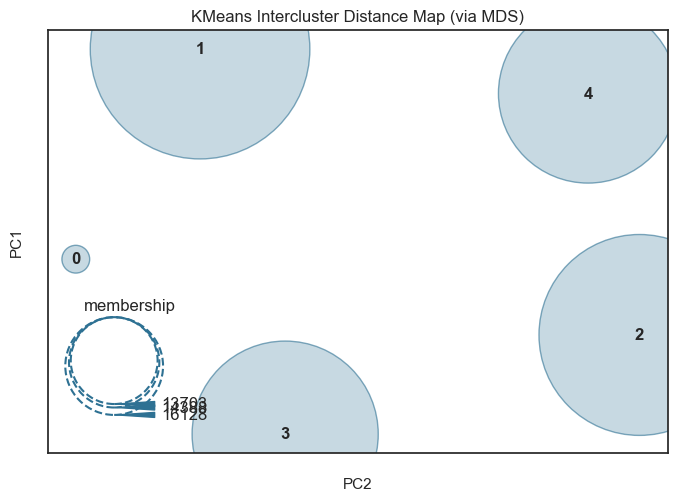

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [106]:
# Visualizing the clusters sizes and distances in a two dimensions graph.
Intercluster_distance_map = InterclusterDistance(kmclust)
Intercluster_distance_map.fit(df_pca_final)
Intercluster_distance_map.show()

In [107]:
# Create a dataframe with the weights per component.
# Here, this dataframe represents the weighted value per feature for all the 20 principal componentes existed, 
# even though we only selected 11 of them.

df_wheight_per_feature = pd.DataFrame(df_pca.components_,columns=df.columns)
df_wheight_per_feature

,Nationality_PRT,Nationality_FRA,Nationality_Other,Nationality_DEU,AverageLeadTime,DistributionChannel_Corporate,DistributionChannel_Travel Agent/Operator,DistributionChannel_Direct,DistributionChannel_GDS Systems,SRKingSizeBed,SRTwinBed,SRQuietRoom,AvgRevenueperYear,Revenueperbooking,Age_gap_51-60,Age_gap_41-50,Age_gap_60+,Age_gap_31-40,Age_gap_20-30,Age_gap_<20
0,0.295002,0.288257,-0.801081,0.217821,-1.512545e-02,0.026621,-0.146652,0.120489,-0.000458,-2.289934e-01,-1.696470e-03,-3.454490e-02,-3.807754e-03,-9.515301e-03,-0.056030,0.197867,-0.048824,-0.069604,-0.021959,-0.001449
1,0.089515,-0.201885,0.301979,-0.189609,-7.526252e-02,0.064559,-0.519393,0.438802,0.016032,-4.428227e-01,5.688607e-02,-7.925344e-02,9.791399e-04,8.183102e-05,-0.129524,0.318030,-0.166324,-0.004270,-0.021389,0.003477
2,0.143045,0.024972,0.009094,-0.177111,-7.406246e-02,0.000531,0.016306,-0.017508,0.000671,6.183402e-01,-3.039411e-01,3.585547e-02,-4.652887e-04,-6.219295e-04,-0.244097,0.571842,-0.279247,-0.017700,-0.019915,-0.010883
3,0.011367,0.115895,-0.076442,-0.050820,-7.561457e-02,0.023404,-0.365717,0.334748,0.007565,3.166206e-01,-2.755059e-01,5.594297e-03,1.402235e-03,3.732977e-03,0.507654,-0.417950,-0.286876,0.186689,0.011778,-0.001296
4,0.001543,0.059465,-0.058467,-0.002541,-2.068991e-02,0.006286,-0.175960,0.167604,0.002071,1.551545e-01,-6.889922e-02,-3.546794e-02,4.168549e-04,-5.249172e-03,-0.643748,-0.289227,0.336867,0.537470,0.054523,0.004114
5,-0.008673,-0.104224,0.004173,0.108723,7.954780e-02,0.010911,-0.255976,0.245305,-0.000241,2.739416e-01,-1.337514e-01,1.501186e-02,3.670370e-03,5.049048e-03,0.022639,-0.009746,0.620662,-0.604420,-0.026898,-0.002236
6,-0.330088,0.740204,0.064847,-0.474963,-4.505153e-02,-0.026699,-0.015482,0.043731,-0.001550,-8.752626e-02,3.424834e-02,-5.376138e-03,4.911103e-03,1.537827e-02,-0.075143,0.001987,0.043309,-0.205531,0.222222,0.013156
7,0.208632,-0.209132,-0.031528,0.032027,-5.592767e-02,0.008435,0.011809,-0.018696,-0.001548,4.322021e-02,5.886083e-02,-6.589742e-02,2.984049e-03,-4.145173e-03,-0.171140,-0.212745,-0.224288,-0.247145,0.843355,0.011963
8,-0.668518,0.052649,0.011633,0.604236,1.257987e-01,-0.053705,-0.109629,0.156820,0.006514,6.789736e-02,5.118029e-02,9.957268e-02,1.403632e-02,2.916439e-02,-0.105677,0.172542,-0.228129,0.010133,0.134798,0.016333
9,0.114763,0.024386,-0.046924,-0.092225,5.584790e-02,-0.028850,-0.103263,0.144612,-0.012499,3.602784e-01,8.700250e-01,2.089327e-01,9.945589e-03,1.455040e-02,0.041984,0.014272,-0.039806,0.025943,-0.065997,0.023604


In [108]:
# Study the weights of component 11.
# For exemplification, here we have the weighted importance per feature regarding the 11 cumulative components.

components_11 = abs(df_wheight_per_feature.iloc[10])  # Since index 10 represents component 11
components_11 = components_11.sort_values(ascending=False)
components_11

SRQuietRoom                                  0.964581
SRTwinBed                                    0.174029
SRKingSizeBed                                0.152011
Nationality_PRT                              0.071473
Age_gap_20-30                                0.057069
Nationality_DEU                              0.045883
Age_gap_51-60                                0.042659
AverageLeadTime                              0.040151
Age_gap_41-50                                0.033330
Nationality_FRA                              0.026467
Age_gap_60+                                  0.014879
Revenueperbooking                            0.011548
DistributionChannel_Direct                   0.008379
Age_gap_<20                                  0.004817
DistributionChannel_Corporate                0.004114
DistributionChannel_GDS Systems              0.002937
DistributionChannel_Travel Agent/Operator    0.001328
Nationality_Other                            0.000876
Age_gap_31-40               

- **4.4) Assess model**
- 4.4.1) Assessing using R2

In [109]:
all_columns = list(df)

In [110]:
# First, we are assessing our clustering solution by using R²:

df_kmeans_r2 =  get_r2(df_kmeans, "df_km_labels")
print("Kmeans Cluster final solution with R² of %0.4f" % df_kmeans_r2);

# Second, we are essentially decomposing the R² into the R² per variable:

get_r2_feature(df_kmeans[all_columns + ['df_km_labels']], 'df_km_labels').drop('df_km_labels').sort_values(axis=0, ascending=False)

Kmeans Cluster final solution with R² of 0.6413


Age_gap_51-60                                1.000000
Age_gap_31-40                                1.000000
Age_gap_41-50                                0.993310
Age_gap_60+                                  0.985834
Age_gap_20-30                                0.857039
Age_gap_<20                                  0.087433
AverageLeadTime                              0.043097
Nationality_PRT                              0.039490
Nationality_DEU                              0.020702
SRTwinBed                                    0.008331
DistributionChannel_Travel Agent/Operator    0.008216
AvgRevenueperYear                            0.005465
Revenueperbooking                            0.005234
Nationality_Other                            0.004508
DistributionChannel_Direct                   0.004391
DistributionChannel_Corporate                0.003121
SRQuietRoom                                  0.002116
Nationality_FRA                              0.001877
DistributionChannel_GDS Syst

- **From the table above, we can conclude that:**: 
    - The final global R2 value for our final cluster solution is 0.6413.
    - The three variables that mostly contribute to the this R2 value are: the age related segments.

- **4.4) Assess model**
- 4.4.2) Interpreting Clustering Algorithms

In [111]:
# Compute the transpose (after scalling for the sake of an easier interpretation).

df_kmeans_meanT = df_kmeans_mean.T

# Compute the transpose (before scalling for the sake of an easier interpretation).

df_before_scaling_kmeansT = df_before_scaling_kmeans_mean.T
df_before_scaling_kmeansT

df_km_labels,0,1,2,3,4
Nationality_PRT,0.094347,0.239970,0.088852,0.070128,0.112676
Nationality_FRA,0.178096,0.139649,0.160466,0.132611,0.162957
Nationality_Other,0.623649,0.536981,0.594680,0.583055,0.623294
Nationality_DEU,0.103907,0.083399,0.156002,0.214206,0.101073
AverageLeadTime,74.303928,74.893036,87.031312,114.466778,67.012406
DistributionChannel_Corporate,0.018288,0.042332,0.026662,0.018071,0.028607
DistributionChannel_Travel Agent/Operator,0.838736,0.783700,0.836000,0.883028,0.815296
DistributionChannel_Direct,0.137053,0.163425,0.130270,0.097303,0.145589
DistributionChannel_GDS Systems,0.005923,0.010544,0.007068,0.001599,0.010509
SRKingSizeBed,0.364817,0.337076,0.358507,0.343967,0.380793


- **Cluster 0**: 
- **Young customers living in the moment**
    - Age_gap:20-30 and < 20
    - The highest value of  French Nationality and Other Nationality 	
    - The lowest value of AverageLeadTime 
    - Distribution Channel: Travel Agent/Operator
    - The second highest value of SRKingSizeBed	and SRTwinBed	
    - The lowest value of SRQuietRoom
    - The highest value of AvgRevenueperYear	
    - The highest value of Revenueperbooking
    - The lowest frequency and magnitude
    
- **Cluster 1**: 
- **Portugueses Clients**
    - Age_gap: 41-50
    - The highest value of  Portuguese Nationality 0.239
    - Distribution Channel: Corporate 0.042332 and Direct 0.163
    - The highest frequency
    
- **Cluster 2**: 
- **Potencial and Mature Clientes**
    - Age_gap: 51-60
    - Within the nationality classes, the one with the highest value of nacionality is Others 0.595
    - Distribution Channel: GDS Systems
    - The highest value of SRQuietRoom
    - The second highest value Revenueperbooking and AverageLeadTime
    - The second highest frequency 
    
- **Cluster 3**: 
- **Advanced Booking Customers** 
    - Age_gap: 60+
    - The highest value of  German Nationality	
    - The highest value of AverageLeadTime 	
    - Distribution Channel: Travel Agent/Operator 	
    - The highest value of SRTwinBed
    - The second highest value of AvgRevenueperYear
    
- **Cluster 4**: 
- **Complicated Clients**
    - Age_gap: 31-40
    - Within the nationality classes, the one with the highest value of nacionality is Others 0.623
    - Distribution Channel: Direct (second) 0.145
    - The highest value of SRKingSizeBed
    - The lowest value of AvgRevenueperYear
    - The lowest value of Revenueperbooking